In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%aimport plot_AUPRC
%aimport AD_predictor_tools

import seaborn as sns

# Goal: Consistently evaluate predictors on human TFs

First AUPRC curve to get best threshold.


For each predictor at tile length of X:


Strategy:
1. Limit human TFs to those containing at least one annotated, acidic activation domain
2. Tile those human TFs at X AA with window spacing of XAA
3. For each tile, compile positives/negatives by:
    
    3.1 Record whether it overlaps >=X/2 AA of an AD annotation
    
    3.2 Record whether it overlaps >=X/2 AA of a DBD annotation
    
    3.3 Remove tiles which overlap both AD and DBD annotations. 
    
    3.4 If overlaps only known AD: Positive. 
    
    3.5 If overlaps only known DBD: Negative.
    

In [3]:
## 1. Reading in predictions on TF tiles

In [4]:
adhunter_prepared = pd.read_csv("../../AD_predictor_project/Paper_AD_predictor/AD_predictor/output/TF_pred_output_MZ/adhunter.csv", index_col=0)
adhunter_prepared

,tile,adhunter,GeneName,Start,End
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,39243.560,sp|P23511|NFYA_HUMAN,0,40
1,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,53384.637,sp|P23511|NFYA_HUMAN,1,41
2,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,52118.496,sp|P23511|NFYA_HUMAN,2,42
3,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,43326.395,sp|P23511|NFYA_HUMAN,3,43
4,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,46656.620,sp|P23511|NFYA_HUMAN,4,44
...,...,...,...,...,...
879731,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,45052.760,sp|Q9Y5X4|NR2E3_HUMAN,366,406
879732,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,50140.586,sp|Q9Y5X4|NR2E3_HUMAN,367,407
879733,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,50458.750,sp|Q9Y5X4|NR2E3_HUMAN,368,408
879734,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,50317.457,sp|Q9Y5X4|NR2E3_HUMAN,369,409


In [5]:
adpred_prepared = pd.read_csv("../../AD_predictor_project/Paper_AD_predictor/AD_predictor/output/TF_pred_output_MZ/adpred.csv", index_col=0)
adpred_prepared

,tile,adpred,GeneName,Start,End
15,MEQYTANSNSSTEQIVVQAGQIQQQQQGGV,0.000659,sp|P23511|NFYA_HUMAN,0,30
16,EQYTANSNSSTEQIVVQAGQIQQQQQGGVT,0.000570,sp|P23511|NFYA_HUMAN,1,31
17,QYTANSNSSTEQIVVQAGQIQQQQQGGVTA,0.000386,sp|P23511|NFYA_HUMAN,2,32
18,YTANSNSSTEQIVVQAGQIQQQQQGGVTAV,0.000753,sp|P23511|NFYA_HUMAN,3,33
19,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQ,0.000351,sp|P23511|NFYA_HUMAN,4,34
...,...,...,...,...,...
947949,SLRFITAERIELLFFRKTIGNTPMEKLLCD,0.035273,sp|Q9Y5X4|NR2E3_HUMAN,376,406
947950,LRFITAERIELLFFRKTIGNTPMEKLLCDM,0.040644,sp|Q9Y5X4|NR2E3_HUMAN,377,407
947951,RFITAERIELLFFRKTIGNTPMEKLLCDMF,0.146967,sp|Q9Y5X4|NR2E3_HUMAN,378,408
947952,FITAERIELLFFRKTIGNTPMEKLLCDMFK,0.105325,sp|Q9Y5X4|NR2E3_HUMAN,379,409


In [6]:
tada_prepared = pd.read_csv("../../AD_predictor_project/Paper_AD_predictor/AD_predictor/output/TF_pred_output_MZ/tada.csv", index_col=0)
tada_prepared = tada_prepared.rename(columns = {"GeneName" : "uniprotID"})
tada_prepared

,uniprotID,tile,Start,End,tada
0,P23511,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,0,40,0.159213
1,P23511,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,1,41,0.158835
2,P23511,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,2,42,0.159775
3,P23511,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,3,43,0.157610
4,P23511,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,4,44,0.157809
...,...,...,...,...,...
879731,Q9Y5X4,RFGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCD,366,406,0.171706
879732,Q9Y5X4,FGKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDM,367,407,0.176539
879733,Q9Y5X4,GKLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMF,368,408,0.187182
879734,Q9Y5X4,KLLLLLPSLRFITAERIELLFFRKTIGNTPMEKLLCDMFK,369,409,0.190598


In [7]:
paddle_prepared = pd.read_csv("../../AD_predictor_project/Paper_AD_predictor/AD_predictor/output/TF_pred_output_MZ/paddle.csv", index_col=0)
paddle_prepared

,tile,preds,GeneName,Start,End
0,MKRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQK...,-0.050897,sp|P17019|ZN708_HUMAN,0,53
1,KRHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKG...,-0.049498,sp|P17019|ZN708_HUMAN,1,54
2,RHEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGC...,-0.050370,sp|P17019|ZN708_HUMAN,2,55
3,HEMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGCK...,-0.052431,sp|P17019|ZN708_HUMAN,3,56
4,EMAAKPPAMCSHFAKDLRPEQYIKNSFQQVILRRYGKCGYQKGCKS...,-0.055883,sp|P17019|ZN708_HUMAN,4,57
...,...,...,...,...,...
747198,SPGCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDRE...,0.497632,sp|O15409|FOXP2_HUMAN,658,711
747199,PGCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREI...,0.515655,sp|O15409|FOXP2_HUMAN,659,712
747200,GCSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREIE...,0.537844,sp|O15409|FOXP2_HUMAN,660,713
747201,CSPQPHIHSIHVKEEPVIAEDEDCPMSLVTTANHSPELEDDREIEE...,0.551399,sp|O15409|FOXP2_HUMAN,661,714


In [8]:
parrot_erij_prepared = pd.read_csv("../data/tf_30_AA_parrot_erij_pred.csv", index_col=0)
parrot_erij_prepared["erij_pred"]= parrot_erij_prepared["erij_pred"].str.replace("[", "")
parrot_erij_prepared["erij_pred"]= parrot_erij_prepared["erij_pred"].str.replace("]", "")
parrot_erij_prepared["erij_pred"] = parrot_erij_prepared["erij_pred"].str.split(r'\s+')
parrot_erij_prepared["erij_pred"] = parrot_erij_prepared["erij_pred"].apply(lambda x: float(x[1]))
parrot_erij_prepared["uniprotID"] = parrot_erij_prepared["GeneName"].str.split("|").str[1]
parrot_erij_prepared = parrot_erij_prepared[["ProteinWindowSeq", "GeneName", "StartPosition", "EndPosition", "erij_pred"]]
parrot_erij_prepared = parrot_erij_prepared.rename(columns = {"ProteinWindowSeq" : "tile",
                                                              "StartPosition" : "Start",
                                                              "EndPosition" : "End"})
parrot_erij_prepared

,tile,GeneName,Start,End,erij_pred
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVL,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,30,0.027907
1,EPEGRGSLFEDSDLLHAGNPKENDVTAVLL,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,1,31,0.023841
2,PEGRGSLFEDSDLLHAGNPKENDVTAVLLT,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,2,32,0.024626
3,EGRGSLFEDSDLLHAGNPKENDVTAVLLTP,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,3,33,0.028051
4,GRGSLFEDSDLLHAGNPKENDVTAVLLTPG,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,4,34,0.025698
...,...,...,...,...,...
903093,ARKIMRFLRRCRHSPLVDHRLYKRSERIEK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1639,1669,0.018220
903094,RKIMRFLRRCRHSPLVDHRLYKRSERIEKG,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1640,1670,0.014282
903095,KIMRFLRRCRHSPLVDHRLYKRSERIEKGQ,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1641,1671,0.015638
903096,IMRFLRRCRHSPLVDHRLYKRSERIEKGQG,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1642,1672,0.023222


In [9]:
parrot_erij_prepared

,tile,GeneName,Start,End,erij_pred
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVL,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,30,0.027907
1,EPEGRGSLFEDSDLLHAGNPKENDVTAVLL,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,1,31,0.023841
2,PEGRGSLFEDSDLLHAGNPKENDVTAVLLT,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,2,32,0.024626
3,EGRGSLFEDSDLLHAGNPKENDVTAVLLTP,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,3,33,0.028051
4,GRGSLFEDSDLLHAGNPKENDVTAVLLTPG,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,4,34,0.025698
...,...,...,...,...,...
903093,ARKIMRFLRRCRHSPLVDHRLYKRSERIEK,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1639,1669,0.018220
903094,RKIMRFLRRCRHSPLVDHRLYKRSERIEKG,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1640,1670,0.014282
903095,KIMRFLRRCRHSPLVDHRLYKRSERIEKGQ,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1641,1671,0.015638
903096,IMRFLRRCRHSPLVDHRLYKRSERIEKGQG,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1642,1672,0.023222


In [10]:
parrot_paddle_prepared = pd.read_csv("../data/tf_53_AA_parrot_paddle_pred.csv", index_col=0)
parrot_paddle_prepared = parrot_paddle_prepared[["ProteinWindowSeq", "GeneName", "StartPosition", "EndPosition", "padd_pred"]]
parrot_paddle_prepared["padd_pred"]= parrot_paddle_prepared["padd_pred"].str.replace("[", "")
parrot_paddle_prepared["padd_pred"]= parrot_paddle_prepared["padd_pred"].str.replace("]", "")
parrot_paddle_prepared["padd_pred"] = parrot_paddle_prepared["padd_pred"].str.split(r'\s+')
parrot_paddle_prepared["padd_pred"] = parrot_paddle_prepared["padd_pred"].apply(lambda x: float(x[0]))
parrot_paddle_prepared["uniprotID"] = parrot_paddle_prepared["GeneName"].str.split("|").str[1]
parrot_paddle_prepared = parrot_paddle_prepared.rename(columns = {"ProteinWindowSeq" : "tile",
                                                              "StartPosition" : "Start",
                                                              "EndPosition" : "End"})
parrot_paddle_prepared

,tile,GeneName,Start,End,padd_pred,uniprotID
0,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,0,53,0.958388,A0A087WUV0
1,EPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEAL...,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,1,54,1.116155,A0A087WUV0
2,PEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEALT...,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,2,55,1.312642,A0A087WUV0
3,EGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEALTQ...,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,3,56,1.055705,A0A087WUV0
4,GRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEALTQW...,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,4,57,1.152435,A0A087WUV0
...,...,...,...,...,...,...
865994,RRTAVIVQQKLRSSLLTKKQDQAARKIMRFLRRCRHSPLVDHRLYK...,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1616,1669,-0.021582,Q9Y6Y1
865995,RTAVIVQQKLRSSLLTKKQDQAARKIMRFLRRCRHSPLVDHRLYKR...,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1617,1670,-0.057513,Q9Y6Y1
865996,TAVIVQQKLRSSLLTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRS...,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1618,1671,-0.083714,Q9Y6Y1
865997,AVIVQQKLRSSLLTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSE...,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,1619,1672,-0.056512,Q9Y6Y1


Best threshold for adhunter:56588.035
Best threshold for adhunter:59645.086


Text(0.5, 0.98, 'ADHunter: 32AA Lambert TF Windows')

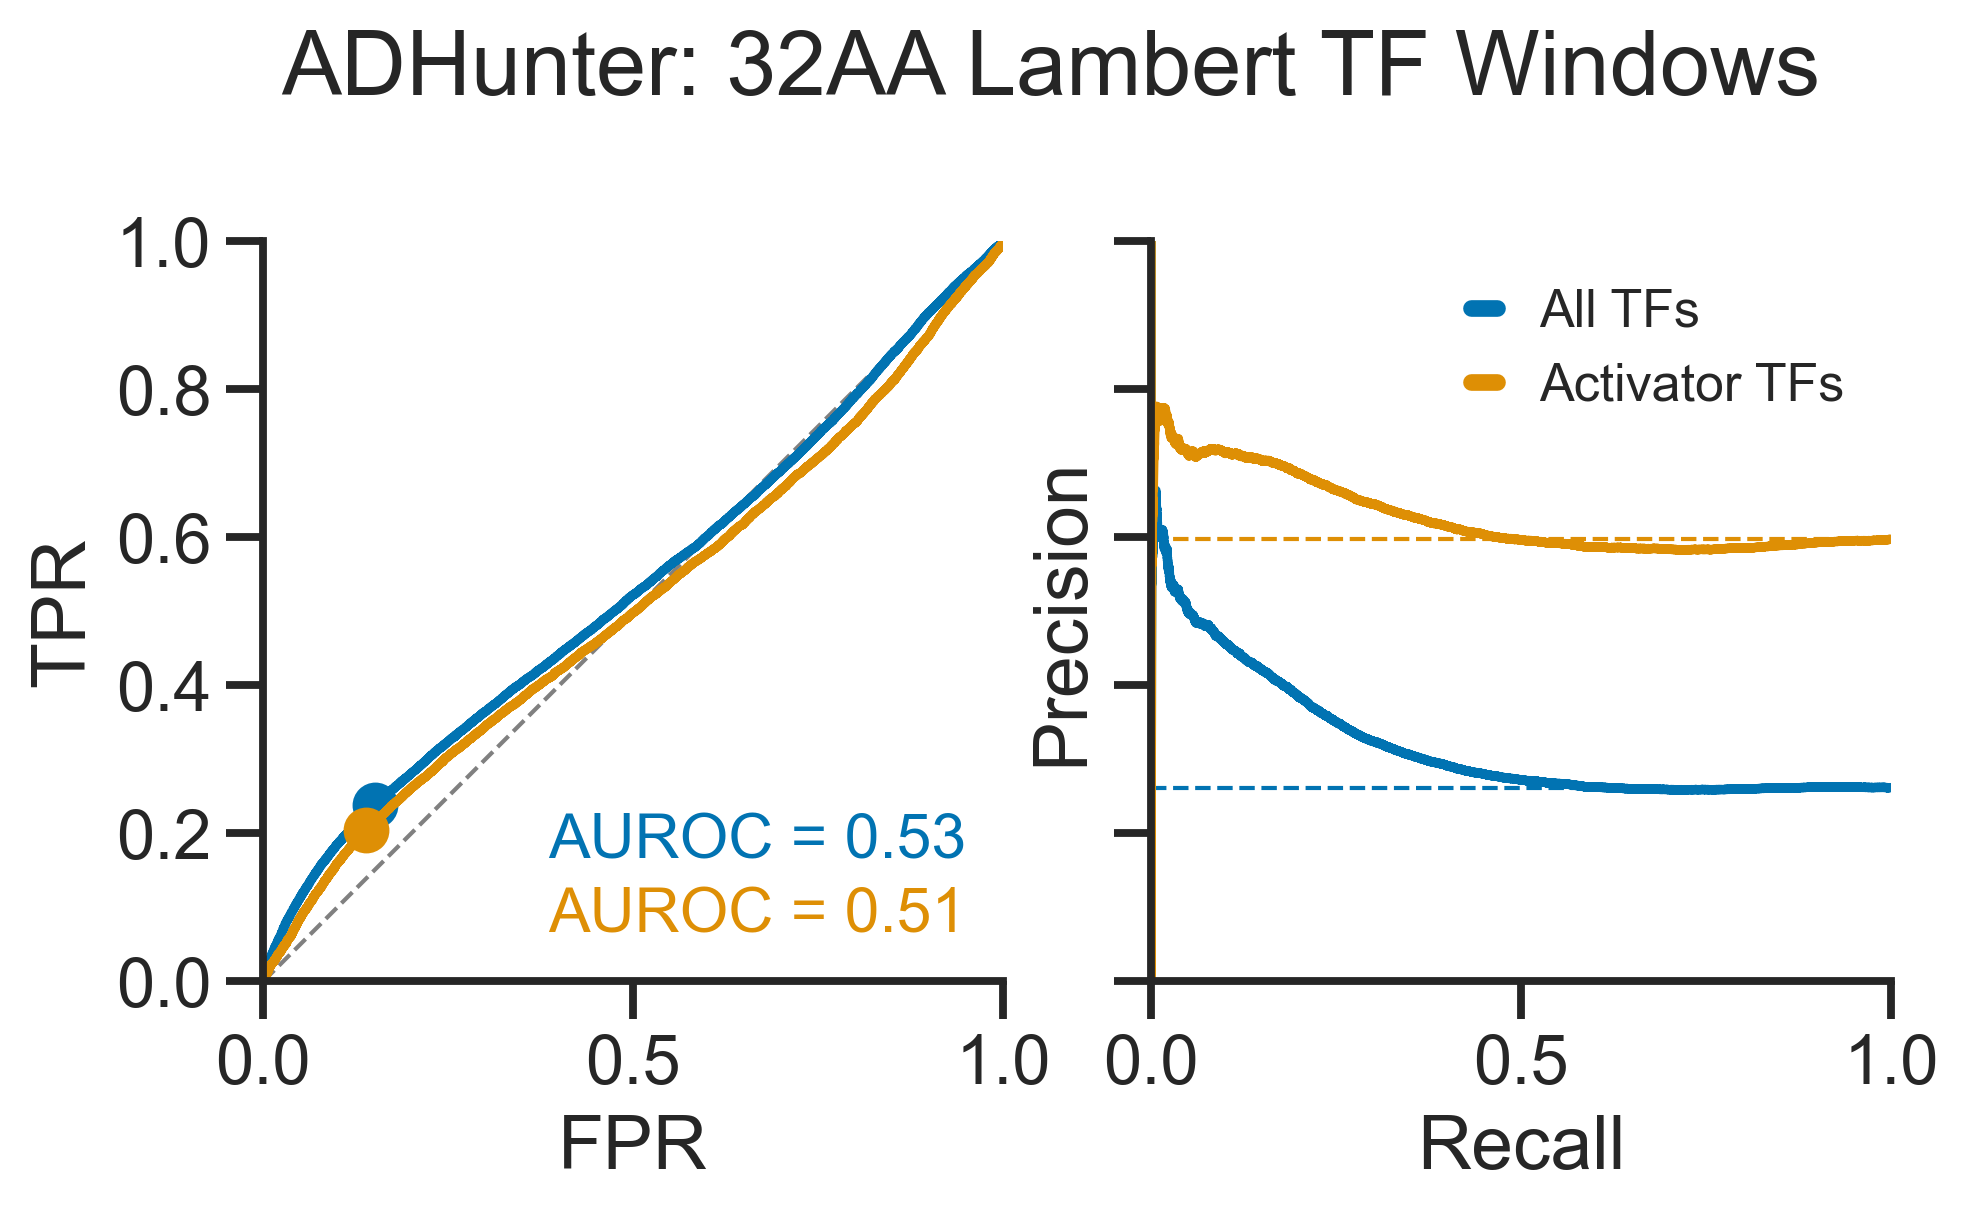

In [18]:
adhunter_output = plot_AUPRC.plot_one_predictor_pair(adhunter_prepared, "adhunter", 32)
plt.suptitle("ADHunter: 32AA Lambert TF Windows")

Best threshold for preds (F1 score): 0.1091
Best F1 score for preds: 0.5776
Best threshold for preds (F1 score): -0.0696
Best F1 score for preds: 0.7537


Text(0.5, 0.98, 'paddle: 53AA Lambert TF Windows')

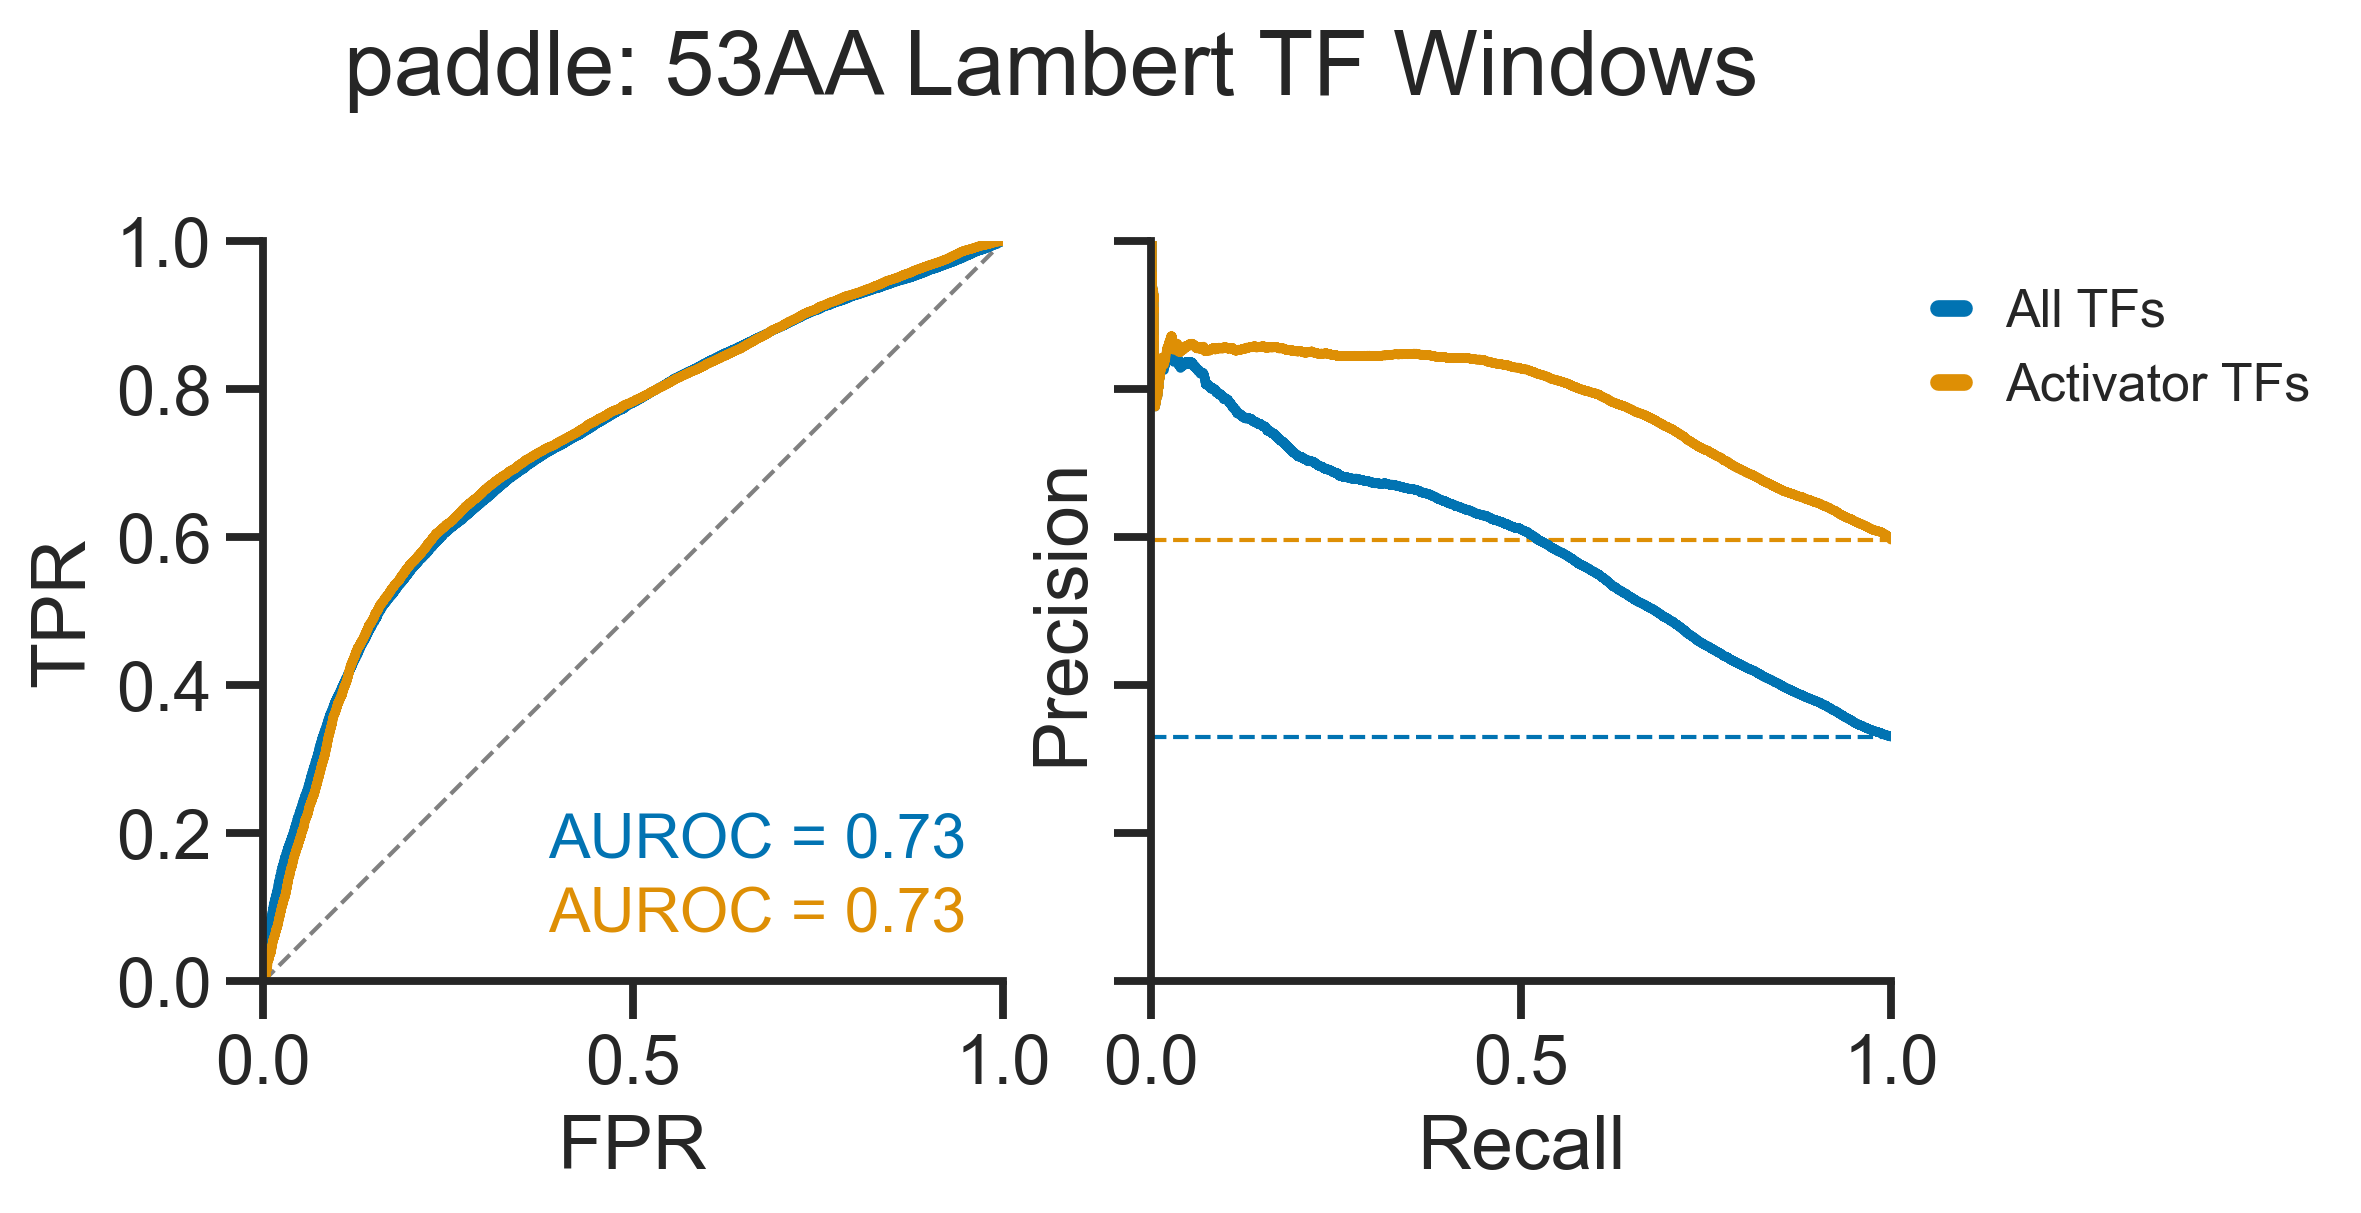

In [ ]:
paddle_output = plot_AUPRC.plot_one_predictor_pair(paddle_prepared, "preds", 42)
plt.suptitle("paddle: 53AA Lambert TF Windows")

Best threshold for tada (F1 score): 0.1753
Best F1 score for tada: 0.4470
Best threshold for tada (F1 score): 0.1486
Best F1 score for tada: 0.7484


Text(0.5, 0.98, 'tada: 40AA Lambert TF Windows')

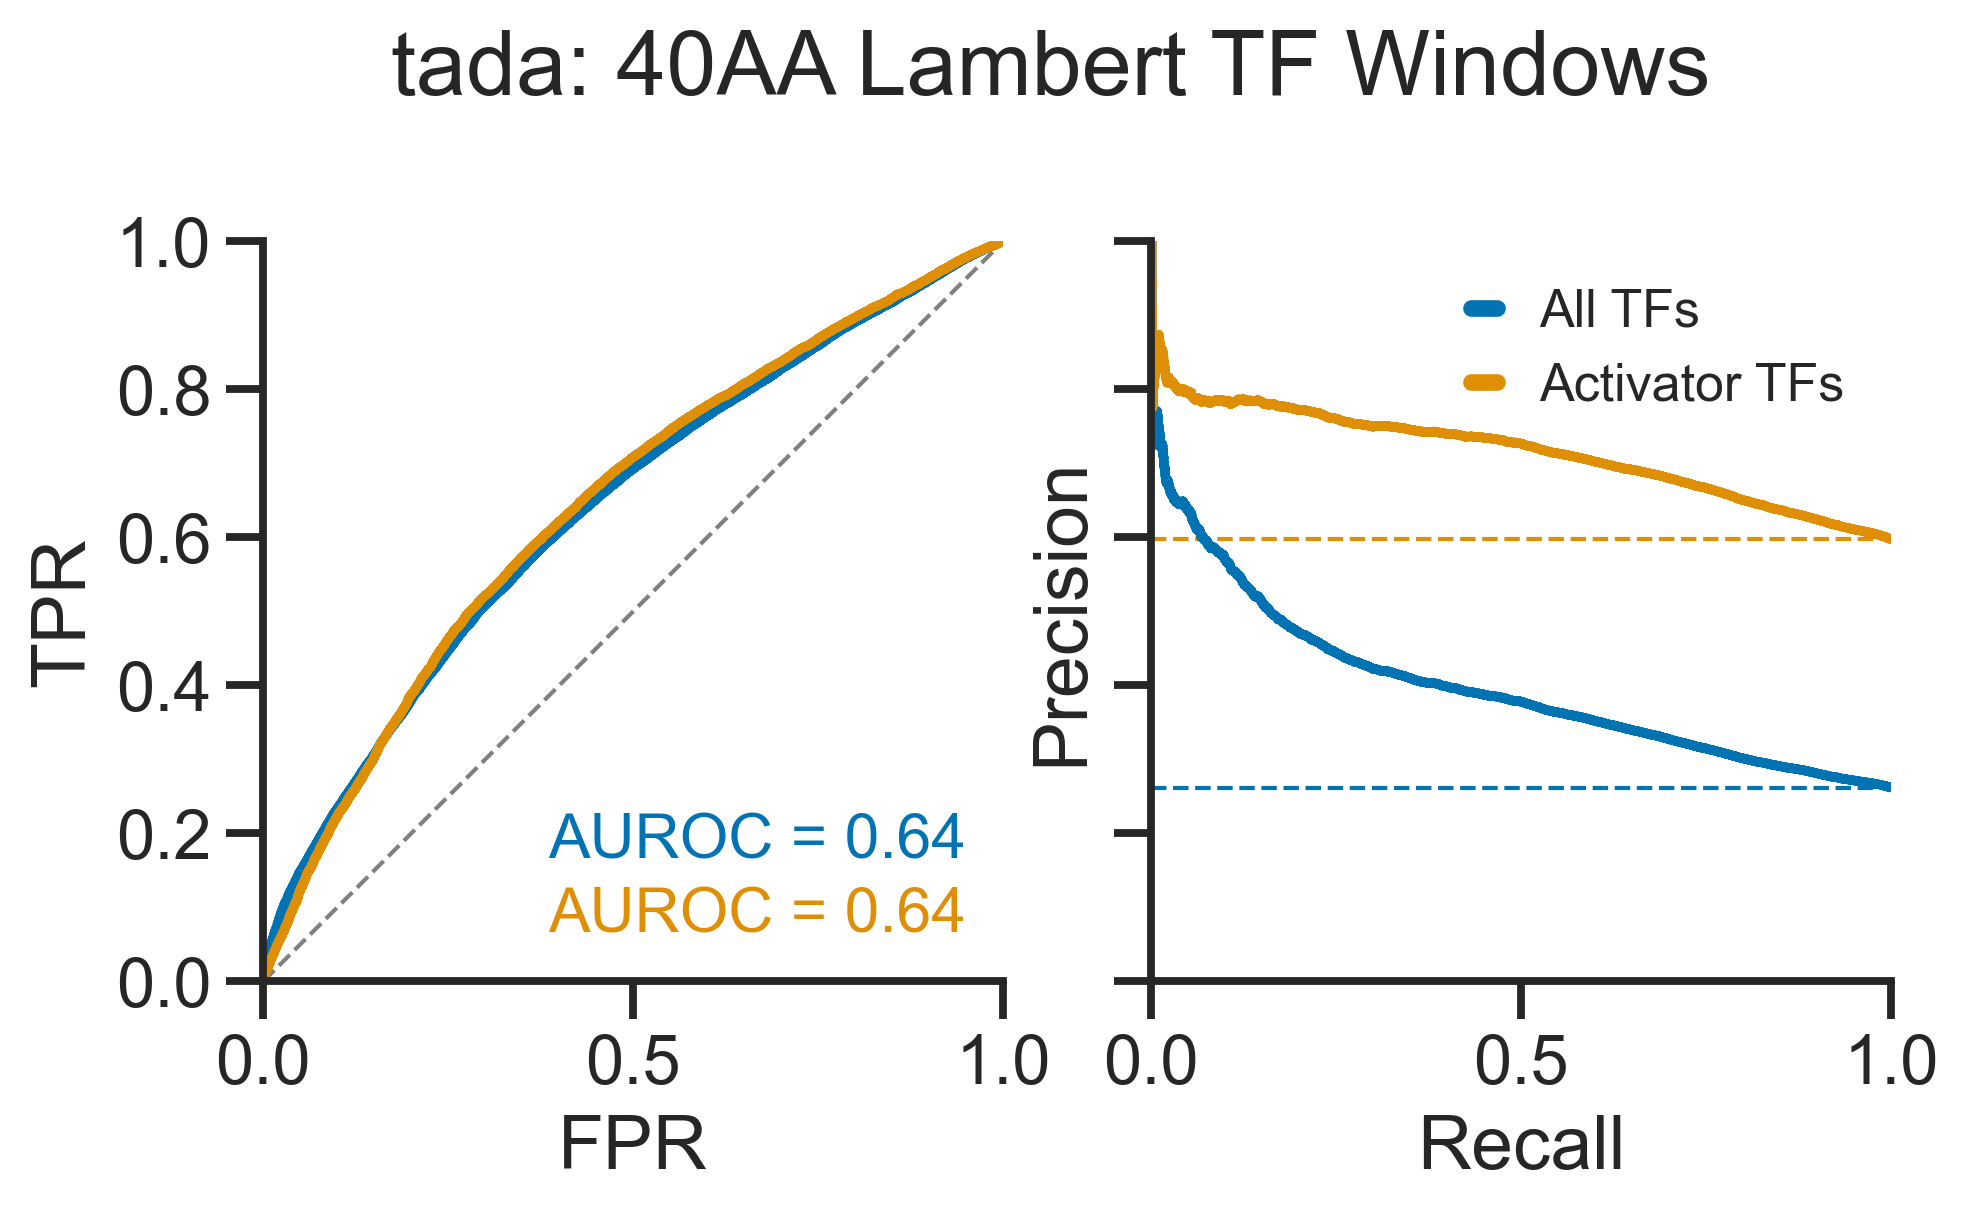

In [ ]:
tada_output = plot_AUPRC.plot_one_predictor(tada_prepared, "tada", 32)
plt.suptitle("tada: 40AA Lambert TF Windows")

Best threshold for adpred (F1 score): 0.0005
Best F1 score for adpred: 0.4330
Best threshold for adpred (F1 score): 0.0001
Best F1 score for adpred: 0.7396


Text(0.5, 0.98, 'adpred: 40AA Lambert TF Windows')

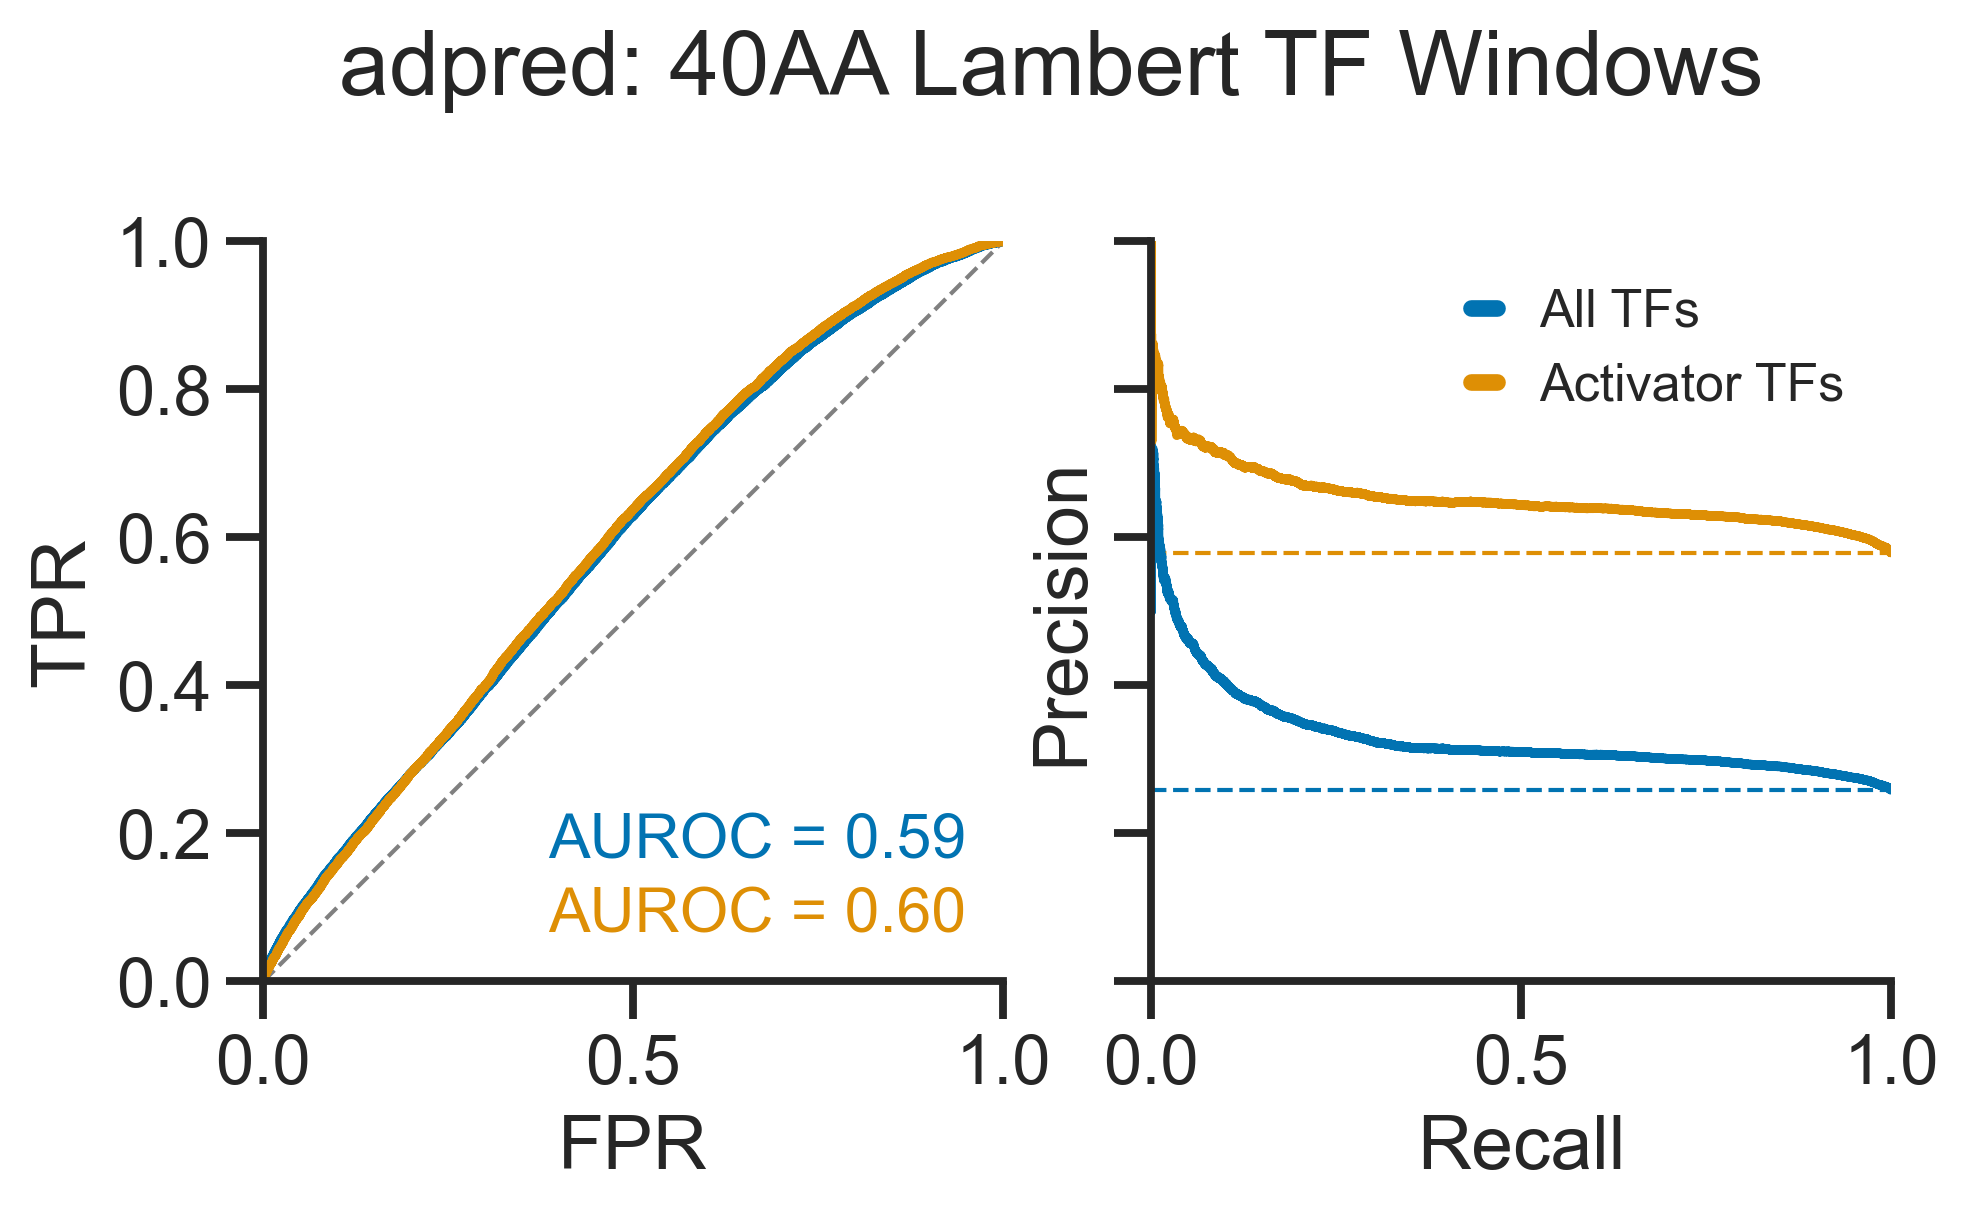

In [ ]:
adpred_output = plot_AUPRC.plot_one_predictor(adpred_prepared, "adpred", 24)
plt.suptitle("adpred: 40AA Lambert TF Windows")

Best threshold for erij_pred (F1 score): 0.0028
Best F1 score for erij_pred: 0.4097
Best threshold for erij_pred (F1 score): 0.0016
Best F1 score for erij_pred: 0.7452


Text(0.5, 0.98, 'PARROT Erij: 30AA Lambert TF Windows')

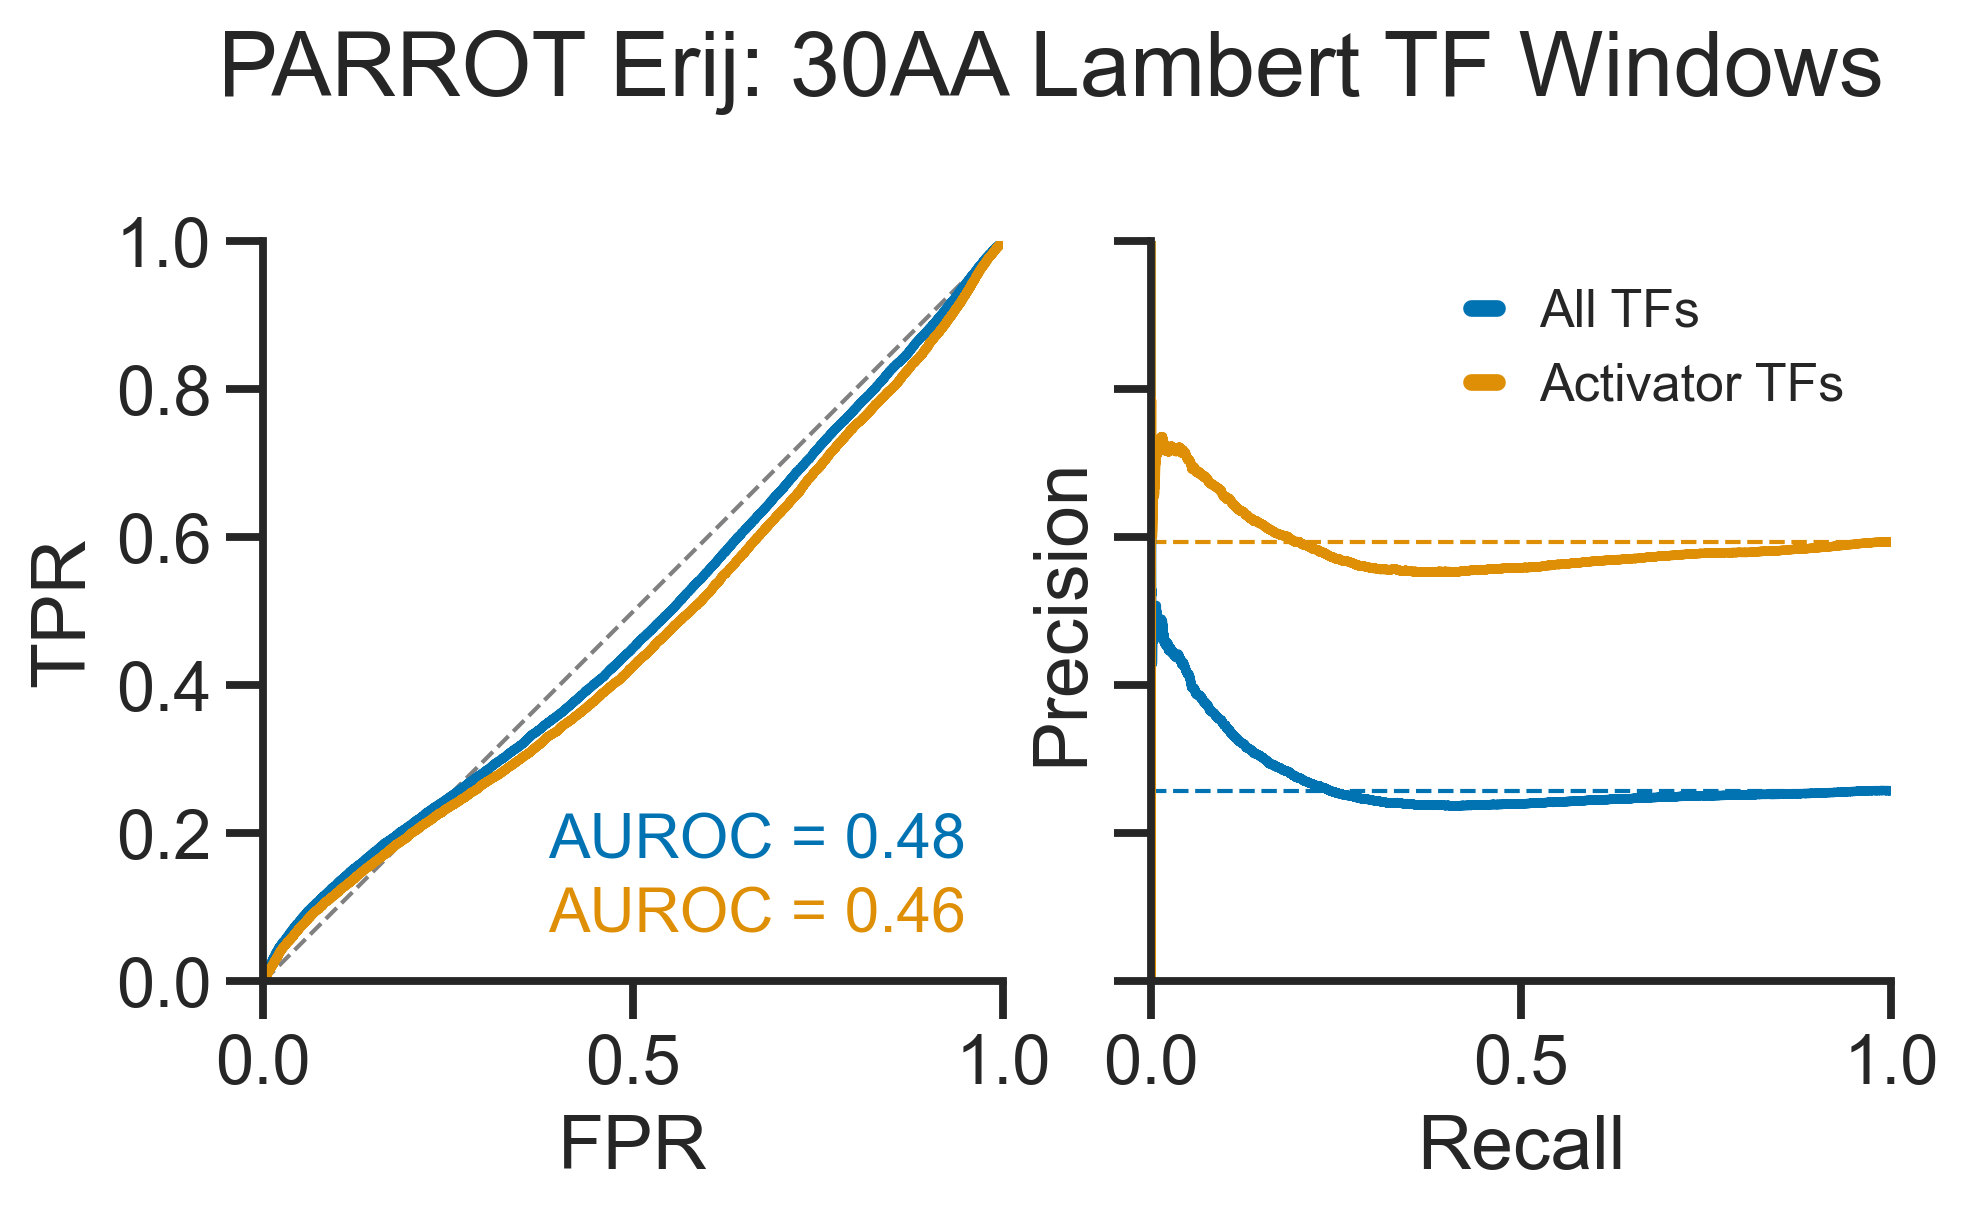

In [ ]:
parrot_erij_output = plot_AUPRC.plot_one_predictor(parrot_erij_prepared, "erij_pred", 24)
plt.suptitle("PARROT Erij: 30AA Lambert TF Windows")

Best threshold for padd_pred (F1 score): 0.1830
Best F1 score for padd_pred: 0.4532
Best threshold for padd_pred (F1 score): -0.6639
Best F1 score for padd_pred: 0.7493


Text(0.5, 0.98, 'PARROT PADDLE: 53AA Lambert TF Windows')

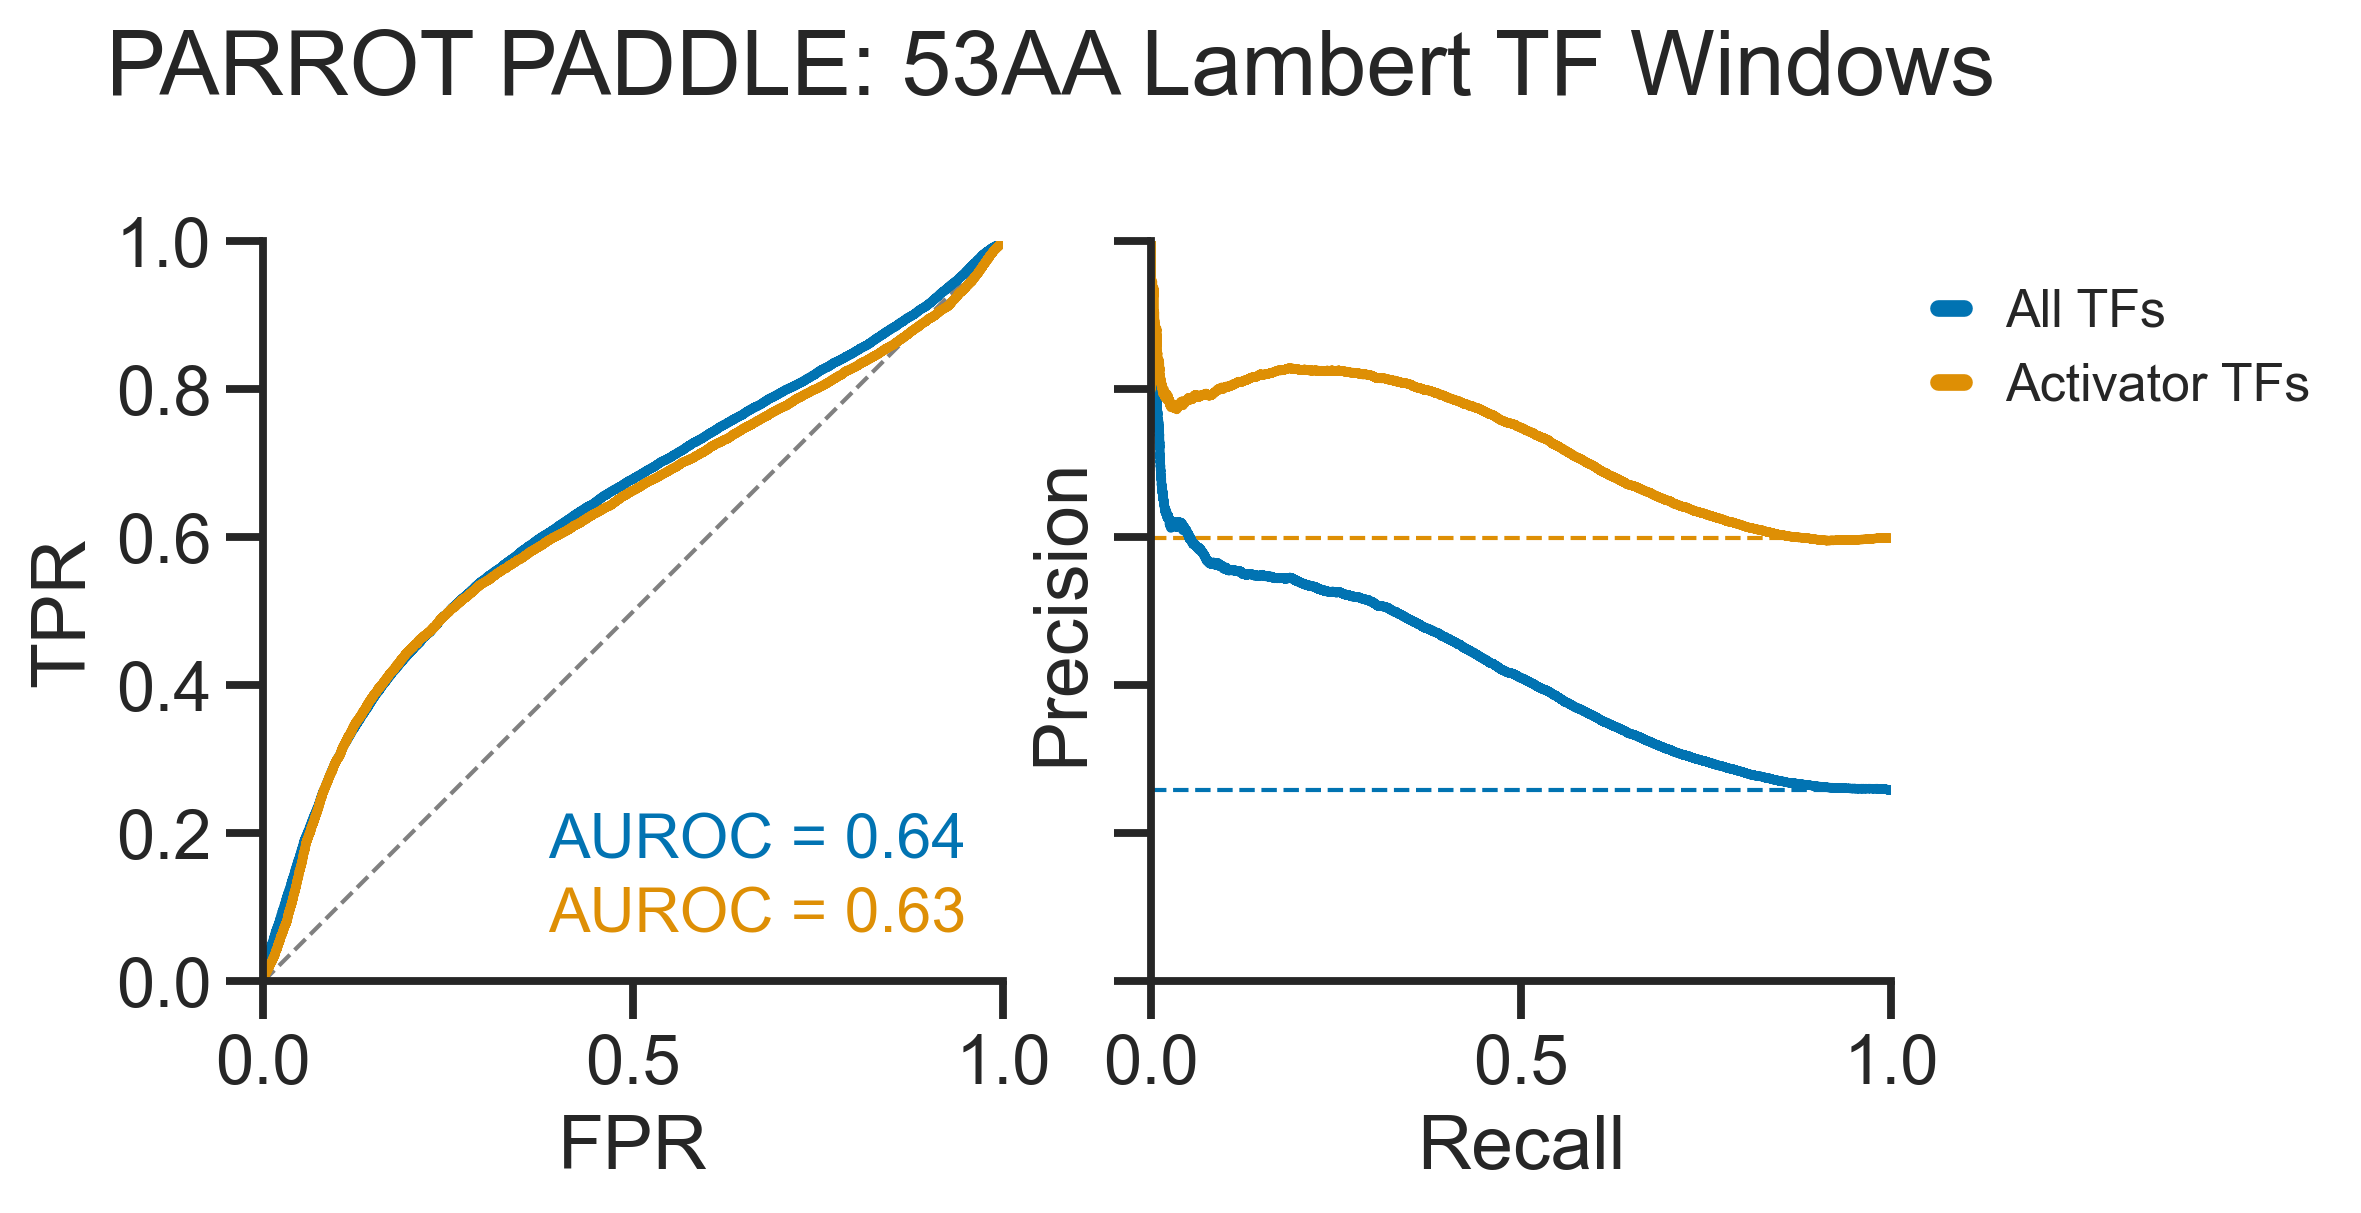

In [ ]:
parrot_paddle_output = plot_AUPRC.plot_one_predictor(parrot_paddle_prepared, "padd_pred", 42)
plt.suptitle("PARROT PADDLE: 53AA Lambert TF Windows")

In [ ]:
## Processing the outputs

In [19]:
adhunter_processed = plot_AUPRC.return_processed_output(adhunter_prepared, 32)
adhunter_processed


,tile,adhunter,GeneName,Start,End,uniprotID,AD_suffic_overlap,DBD_suffic_overlap,annot_count,active
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,39243.560,sp|P23511|NFYA_HUMAN,0,40,P23511,True,False,1,True
1,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,53384.637,sp|P23511|NFYA_HUMAN,1,41,P23511,True,False,1,True
2,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,52118.496,sp|P23511|NFYA_HUMAN,2,42,P23511,True,False,1,True
3,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,43326.395,sp|P23511|NFYA_HUMAN,3,43,P23511,True,False,1,True
4,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,46656.620,sp|P23511|NFYA_HUMAN,4,44,P23511,True,False,1,True
...,...,...,...,...,...,...,...,...,...,...
879444,IYRCQVGAGMCPVDKAHRNQCQACRLKKCLQAGMNQDAVQ,27671.973,sp|Q9Y5X4|NR2E3_HUMAN,79,119,Q9Y5X4,False,True,1,False
879445,YRCQVGAGMCPVDKAHRNQCQACRLKKCLQAGMNQDAVQN,27568.281,sp|Q9Y5X4|NR2E3_HUMAN,80,120,Q9Y5X4,False,True,1,False
879446,RCQVGAGMCPVDKAHRNQCQACRLKKCLQAGMNQDAVQNE,23137.258,sp|Q9Y5X4|NR2E3_HUMAN,81,121,Q9Y5X4,False,True,1,False
879447,CQVGAGMCPVDKAHRNQCQACRLKKCLQAGMNQDAVQNER,22050.934,sp|Q9Y5X4|NR2E3_HUMAN,82,122,Q9Y5X4,False,True,1,False


In [20]:
adpred_processed = plot_AUPRC.return_processed_output(adpred_prepared, 24)
adpred_processed

,tile,adpred,GeneName,Start,End,uniprotID,AD_suffic_overlap,DBD_suffic_overlap,annot_count,active
0,MEQYTANSNSSTEQIVVQAGQIQQQQQGGV,0.000659,sp|P23511|NFYA_HUMAN,0,30,P23511,True,False,1,True
1,EQYTANSNSSTEQIVVQAGQIQQQQQGGVT,0.000570,sp|P23511|NFYA_HUMAN,1,31,P23511,True,False,1,True
2,QYTANSNSSTEQIVVQAGQIQQQQQGGVTA,0.000386,sp|P23511|NFYA_HUMAN,2,32,P23511,True,False,1,True
3,YTANSNSSTEQIVVQAGQIQQQQQGGVTAV,0.000753,sp|P23511|NFYA_HUMAN,3,33,P23511,True,False,1,True
4,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQ,0.000351,sp|P23511|NFYA_HUMAN,4,34,P23511,True,False,1,True
...,...,...,...,...,...,...,...,...,...,...
813926,GMCPVDKAHRNQCQACRLKKCLQAGMNQDA,0.000075,sp|Q9Y5X4|NR2E3_HUMAN,87,117,Q9Y5X4,False,True,1,False
813927,MCPVDKAHRNQCQACRLKKCLQAGMNQDAV,0.000078,sp|Q9Y5X4|NR2E3_HUMAN,88,118,Q9Y5X4,False,True,1,False
813928,CPVDKAHRNQCQACRLKKCLQAGMNQDAVQ,0.000062,sp|Q9Y5X4|NR2E3_HUMAN,89,119,Q9Y5X4,False,True,1,False
813929,PVDKAHRNQCQACRLKKCLQAGMNQDAVQN,0.000053,sp|Q9Y5X4|NR2E3_HUMAN,90,120,Q9Y5X4,False,True,1,False


In [21]:
paddle_processed = plot_AUPRC.return_processed_output(paddle_prepared, 32)
paddle_processed

,tile,preds,GeneName,Start,End,uniprotID,AD_suffic_overlap,DBD_suffic_overlap,annot_count,active
470,TIFNPEVFQPQMALPTDGPYLQILEQPKQRGFRFRYVCEGPSHGGL...,0.595128,sp|P19838|NFKB1_HUMAN,23,76,P19838,False,True,1,False
471,IFNPEVFQPQMALPTDGPYLQILEQPKQRGFRFRYVCEGPSHGGLP...,0.552633,sp|P19838|NFKB1_HUMAN,24,77,P19838,False,True,1,False
472,FNPEVFQPQMALPTDGPYLQILEQPKQRGFRFRYVCEGPSHGGLPG...,0.492379,sp|P19838|NFKB1_HUMAN,25,78,P19838,False,True,1,False
473,NPEVFQPQMALPTDGPYLQILEQPKQRGFRFRYVCEGPSHGGLPGA...,0.437898,sp|P19838|NFKB1_HUMAN,26,79,P19838,False,True,1,False
474,PEVFQPQMALPTDGPYLQILEQPKQRGFRFRYVCEGPSHGGLPGAS...,0.371691,sp|P19838|NFKB1_HUMAN,27,80,P19838,False,True,1,False
...,...,...,...,...,...,...,...,...,...,...
747092,RHNLSLHKCFVRVENVKGAVWTVDEVEYQKRRSQKITGSPTLVKNI...,-0.096897,sp|O15409|FOXP2_HUMAN,552,605,O15409,False,True,1,False
747093,HNLSLHKCFVRVENVKGAVWTVDEVEYQKRRSQKITGSPTLVKNIP...,-0.088876,sp|O15409|FOXP2_HUMAN,553,606,O15409,False,True,1,False
747094,NLSLHKCFVRVENVKGAVWTVDEVEYQKRRSQKITGSPTLVKNIPT...,-0.085727,sp|O15409|FOXP2_HUMAN,554,607,O15409,False,True,1,False
747095,LSLHKCFVRVENVKGAVWTVDEVEYQKRRSQKITGSPTLVKNIPTS...,-0.079341,sp|O15409|FOXP2_HUMAN,555,608,O15409,False,True,1,False


In [22]:
parrot_erij_processed = plot_AUPRC.return_processed_output(parrot_erij_prepared, 24)
parrot_erij_processed

,tile,GeneName,Start,End,erij_pred,uniprotID,AD_suffic_overlap,DBD_suffic_overlap,annot_count,active
601,SQPSRKEKSLGLLCHKFLARYPNYPNPAVN,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,108,138,0.014368,A0AVK6,False,True,1,False
602,QPSRKEKSLGLLCHKFLARYPNYPNPAVNN,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,109,139,0.010990,A0AVK6,False,True,1,False
603,PSRKEKSLGLLCHKFLARYPNYPNPAVNND,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,110,140,0.011023,A0AVK6,False,True,1,False
604,SRKEKSLGLLCHKFLARYPNYPNPAVNNDI,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,111,141,0.011490,A0AVK6,False,True,1,False
605,RKEKSLGLLCHKFLARYPNYPNPAVNNDIC,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,112,142,0.011004,A0AVK6,False,True,1,False
...,...,...,...,...,...,...,...,...,...,...
902267,FTQAEMCLPCCSPQQGSLQLSSSEGGASTM,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,813,843,0.086483,Q9Y6Y1,True,False,1,True
902268,TQAEMCLPCCSPQQGSLQLSSSEGGASTMA,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,814,844,0.027070,Q9Y6Y1,True,False,1,True
902269,QAEMCLPCCSPQQGSLQLSSSEGGASTMAY,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,815,845,0.055237,Q9Y6Y1,True,False,1,True
902270,AEMCLPCCSPQQGSLQLSSSEGGASTMAYM,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,816,846,0.076168,Q9Y6Y1,True,False,1,True


In [23]:
parrot_paddle_processed = plot_AUPRC.return_processed_output(parrot_paddle_prepared, 42)
parrot_paddle_processed

,tile,GeneName,Start,End,padd_pred,uniprotID,AD_suffic_overlap,DBD_suffic_overlap,annot_count,active
573,DEFEKSQPSRKEKSLGLLCHKFLARYPNYPNPAVNNDICLDEVAEE...,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,103,156,0.315656,A0AVK6,False,True,1,False
574,EFEKSQPSRKEKSLGLLCHKFLARYPNYPNPAVNNDICLDEVAEEL...,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,104,157,0.153858,A0AVK6,False,True,1,False
575,FEKSQPSRKEKSLGLLCHKFLARYPNYPNPAVNNDICLDEVAEELN...,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,105,158,0.130131,A0AVK6,False,True,1,False
576,EKSQPSRKEKSLGLLCHKFLARYPNYPNPAVNNDICLDEVAEELNV...,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,106,159,0.759327,A0AVK6,False,True,1,False
577,KSQPSRKEKSLGLLCHKFLARYPNYPNPAVNNDICLDEVAEELNVE...,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,107,160,0.388009,A0AVK6,False,True,1,False
...,...,...,...,...,...,...,...,...,...,...
865173,VSGDSTALSQSEDGARAPFTQAEMCLPCCSPQQGSLQLSSSEGGAS...,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,795,848,0.801763,Q9Y6Y1,True,False,1,True
865174,SGDSTALSQSEDGARAPFTQAEMCLPCCSPQQGSLQLSSSEGGAST...,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,796,849,0.593022,Q9Y6Y1,True,False,1,True
865175,GDSTALSQSEDGARAPFTQAEMCLPCCSPQQGSLQLSSSEGGASTM...,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,797,850,0.904212,Q9Y6Y1,True,False,1,True
865176,DSTALSQSEDGARAPFTQAEMCLPCCSPQQGSLQLSSSEGGASTMA...,sp|Q9Y6Y1|CMTA1_HUMAN Calmodulin-binding trans...,798,851,0.665983,Q9Y6Y1,True,False,1,True


In [24]:
tada_processed = plot_AUPRC.return_processed_output(tada_prepared, 32)
tada_processed

,uniprotID,tile,Start,End,tada,AD_suffic_overlap,DBD_suffic_overlap,annot_count,active
0,P23511,MEQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQ,0,40,0.159213,True,False,1,True
1,P23511,EQYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQV,1,41,0.158835,True,False,1,True
2,P23511,QYTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVA,2,42,0.159775,True,False,1,True
3,P23511,YTANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVAS,3,43,0.157610,True,False,1,True
4,P23511,TANSNSSTEQIVVQAGQIQQQQQGGVTAVQLQTEAQVASA,4,44,0.157809,True,False,1,True
...,...,...,...,...,...,...,...,...,...
879444,Q9Y5X4,IYRCQVGAGMCPVDKAHRNQCQACRLKKCLQAGMNQDAVQ,79,119,0.149012,False,True,1,False
879445,Q9Y5X4,YRCQVGAGMCPVDKAHRNQCQACRLKKCLQAGMNQDAVQN,80,120,0.148220,False,True,1,False
879446,Q9Y5X4,RCQVGAGMCPVDKAHRNQCQACRLKKCLQAGMNQDAVQNE,81,121,0.147023,False,True,1,False
879447,Q9Y5X4,CQVGAGMCPVDKAHRNQCQACRLKKCLQAGMNQDAVQNER,82,122,0.143107,False,True,1,False


In [51]:
sns.set_context('talk')


# color_palette = sns.color_palette('magma_r', 6)
# # Set the palette using sns_palette
# sns.set_palette([(0.5294117647058824, 0.23137254901960785, 0.3803921568627451), (0.5607843137254902, 0.2823529411764706, 0.615686274509804), (0.403921568627451, 0.4823529411764706, 0.8627450980392157), (0.23137254901960785, 0.7529411764705882, 0.7725490196078432), (0.36470588235294116, 0.8980392156862745, 0.47058823529411764), (0.7764705882352941, 0.8627450980392157, 0.39215686274509803), (0.9137254901960784, 0.8352941176470589, 0.4588235294117647)])
# sns.color_palette()

color_palette = [(0.5294117647058824, 0.23137254901960785, 0.3803921568627451), (0.5607843137254902, 0.2823529411764706, 0.615686274509804), (0.403921568627451, 0.4823529411764706, 0.8627450980392157), (0.23137254901960785, 0.7529411764705882, 0.7725490196078432), (0.36470588235294116, 0.8980392156862745, 0.47058823529411764), (0.7764705882352941, 0.8627450980392157, 0.39215686274509803), (0.9137254901960784, 0.8352941176470589, 0.4588235294117647)]

colors = {
    "paddle": color_palette[5],
    "tada": color_palette[4],
    "parrot_paddle": color_palette[6],
    "adpred": color_palette[0],
    "adhunter": color_palette[2],
    "parrot_erij": color_palette[1],
}
def plot_roc(paddle_processed,
             tada_processed,
             adpred_processed,
             adhunter_processed,
             parrot_erij_processed,
             parrot_paddle_processed,
             ax):
    

    ax.plot([0, 1], [0, 1], 'k--', color="gray", lw=1)

    paddle_auc = plot_AUPRC.plot_roc(paddle_processed, "preds", ax=ax, text=False, color=colors["paddle"], custom_threshold=4)
    tada_auc = plot_AUPRC.plot_roc(tada_processed, "tada", ax=ax, text=False, color=colors["tada"])
    adpred_auc = plot_AUPRC.plot_roc(adpred_processed, "adpred", ax=ax, text=False, color=colors["adpred"])
    adhunter_auc = plot_AUPRC.plot_roc(adhunter_processed, "adhunter", ax=ax, text=False, color=colors["adhunter"])
    parrot_erij_auc = plot_AUPRC.plot_roc(parrot_erij_processed, "erij_pred", ax=ax, text=False, color=colors["parrot_erij"])
    parrot_paddle_auc = plot_AUPRC.plot_roc(parrot_paddle_processed, "padd_pred", ax=ax, text=False, color=colors["parrot_paddle"])

    ax.text(x=0.65, y=0.38, s="AUROC:", ha="left", va="bottom", fontsize="small", color = 'black')
    ax.text(x=0.5, y=0.32, s="PADDLE, " + str(round(paddle_auc, 2)), color=colors["paddle"], ha="left", va="bottom", fontsize="x-small")
    ax.text(x=0.5, y=0.26, s="TADA, " + str(round(tada_auc, 2)), color=colors["tada"], ha="left", va="bottom", fontsize="x-small")
    ax.text(x=0.5, y=0.2, s="PARROT Sanborn, " + str(round(parrot_paddle_auc, 2)), color=colors["parrot_paddle"], ha="left", va="bottom", fontsize="x-small")
    ax.text(x=0.5, y=0.14, s="ADPred, " + str(round(adpred_auc, 2)), color=colors["adpred"], ha="left", va="bottom", fontsize="x-small")
    ax.text(x=0.5, y=0.08, s="ADHunter, " + str(round(adhunter_auc, 2)), color=colors["adhunter"], ha="left", va="bottom", fontsize="x-small")
    ax.text(x=0.5, y=0.02, s="PARROT Erijman, " + str(round(parrot_erij_auc, 2)), color=colors["parrot_erij"], ha="left", va="bottom", fontsize="x-small")



In [52]:
paddle_processed

,tile,preds,GeneName,Start,End,uniprotID,AD_suffic_overlap,DBD_suffic_overlap,annot_count,active
470,TIFNPEVFQPQMALPTDGPYLQILEQPKQRGFRFRYVCEGPSHGGL...,0.595128,sp|P19838|NFKB1_HUMAN,23,76,P19838,False,True,1,False
471,IFNPEVFQPQMALPTDGPYLQILEQPKQRGFRFRYVCEGPSHGGLP...,0.552633,sp|P19838|NFKB1_HUMAN,24,77,P19838,False,True,1,False
472,FNPEVFQPQMALPTDGPYLQILEQPKQRGFRFRYVCEGPSHGGLPG...,0.492379,sp|P19838|NFKB1_HUMAN,25,78,P19838,False,True,1,False
473,NPEVFQPQMALPTDGPYLQILEQPKQRGFRFRYVCEGPSHGGLPGA...,0.437898,sp|P19838|NFKB1_HUMAN,26,79,P19838,False,True,1,False
474,PEVFQPQMALPTDGPYLQILEQPKQRGFRFRYVCEGPSHGGLPGAS...,0.371691,sp|P19838|NFKB1_HUMAN,27,80,P19838,False,True,1,False
...,...,...,...,...,...,...,...,...,...,...
747092,RHNLSLHKCFVRVENVKGAVWTVDEVEYQKRRSQKITGSPTLVKNI...,-0.096897,sp|O15409|FOXP2_HUMAN,552,605,O15409,False,True,1,False
747093,HNLSLHKCFVRVENVKGAVWTVDEVEYQKRRSQKITGSPTLVKNIP...,-0.088876,sp|O15409|FOXP2_HUMAN,553,606,O15409,False,True,1,False
747094,NLSLHKCFVRVENVKGAVWTVDEVEYQKRRSQKITGSPTLVKNIPT...,-0.085727,sp|O15409|FOXP2_HUMAN,554,607,O15409,False,True,1,False
747095,LSLHKCFVRVENVKGAVWTVDEVEYQKRRSQKITGSPTLVKNIPTS...,-0.079341,sp|O15409|FOXP2_HUMAN,555,608,O15409,False,True,1,False


In [53]:
known_ADs = pd.read_csv("../../SFARI/output/known_ADs_considering_isoforms_and_canonical_with_alerasool.csv")
known_ADs["charge"] = (
    known_ADs["ProteinRegionSeq"].str.count("R") +
    known_ADs["ProteinRegionSeq"].str.count("K") -
    known_ADs["ProteinRegionSeq"].str.count("D") -
    known_ADs["ProteinRegionSeq"].str.count("E")
)

# Filter to negative
acidic_known_ADs = known_ADs[known_ADs["charge"] < -3]

# Only keep those on TFs
acidic_known_ADs = acidic_known_ADs[acidic_known_ADs["uniprotID"].isin(lambert_TFs["uniprotID"])]
acidic_known_ADs


NameError: name 'lambert_TFs' is not defined

Best threshold for preds:0.20094086
0.05128286751130069 0.003320689901953768

Best threshold for tada:0.1841165
Best threshold for adpred:0.00124123215
Best threshold for adhunter:56588.035
Best threshold for erij_pred:0.15307611
Best threshold for padd_pred:0.24649987
Best threshold for preds:0.17586028
0.05133025330571929 0.005780346820809248

Best threshold for tada:0.18453944
Best threshold for adpred:0.00104797597
Best threshold for adhunter:59645.086
Best threshold for erij_pred:0.17256586
Best threshold for padd_pred:0.24656086
Best threshold for preds:0.19516232
0.07336702227213177 0.007943067033976126

Best threshold for tada:0.18291214
Best threshold for adpred:0.00238765217
Best threshold for adhunter:60805.043
Best threshold for erij_pred:0.281502
Best threshold for padd_pred:0.31931672


Text(-0.6, 0.5, 'Acidic\nActivator\nTF Tiles')

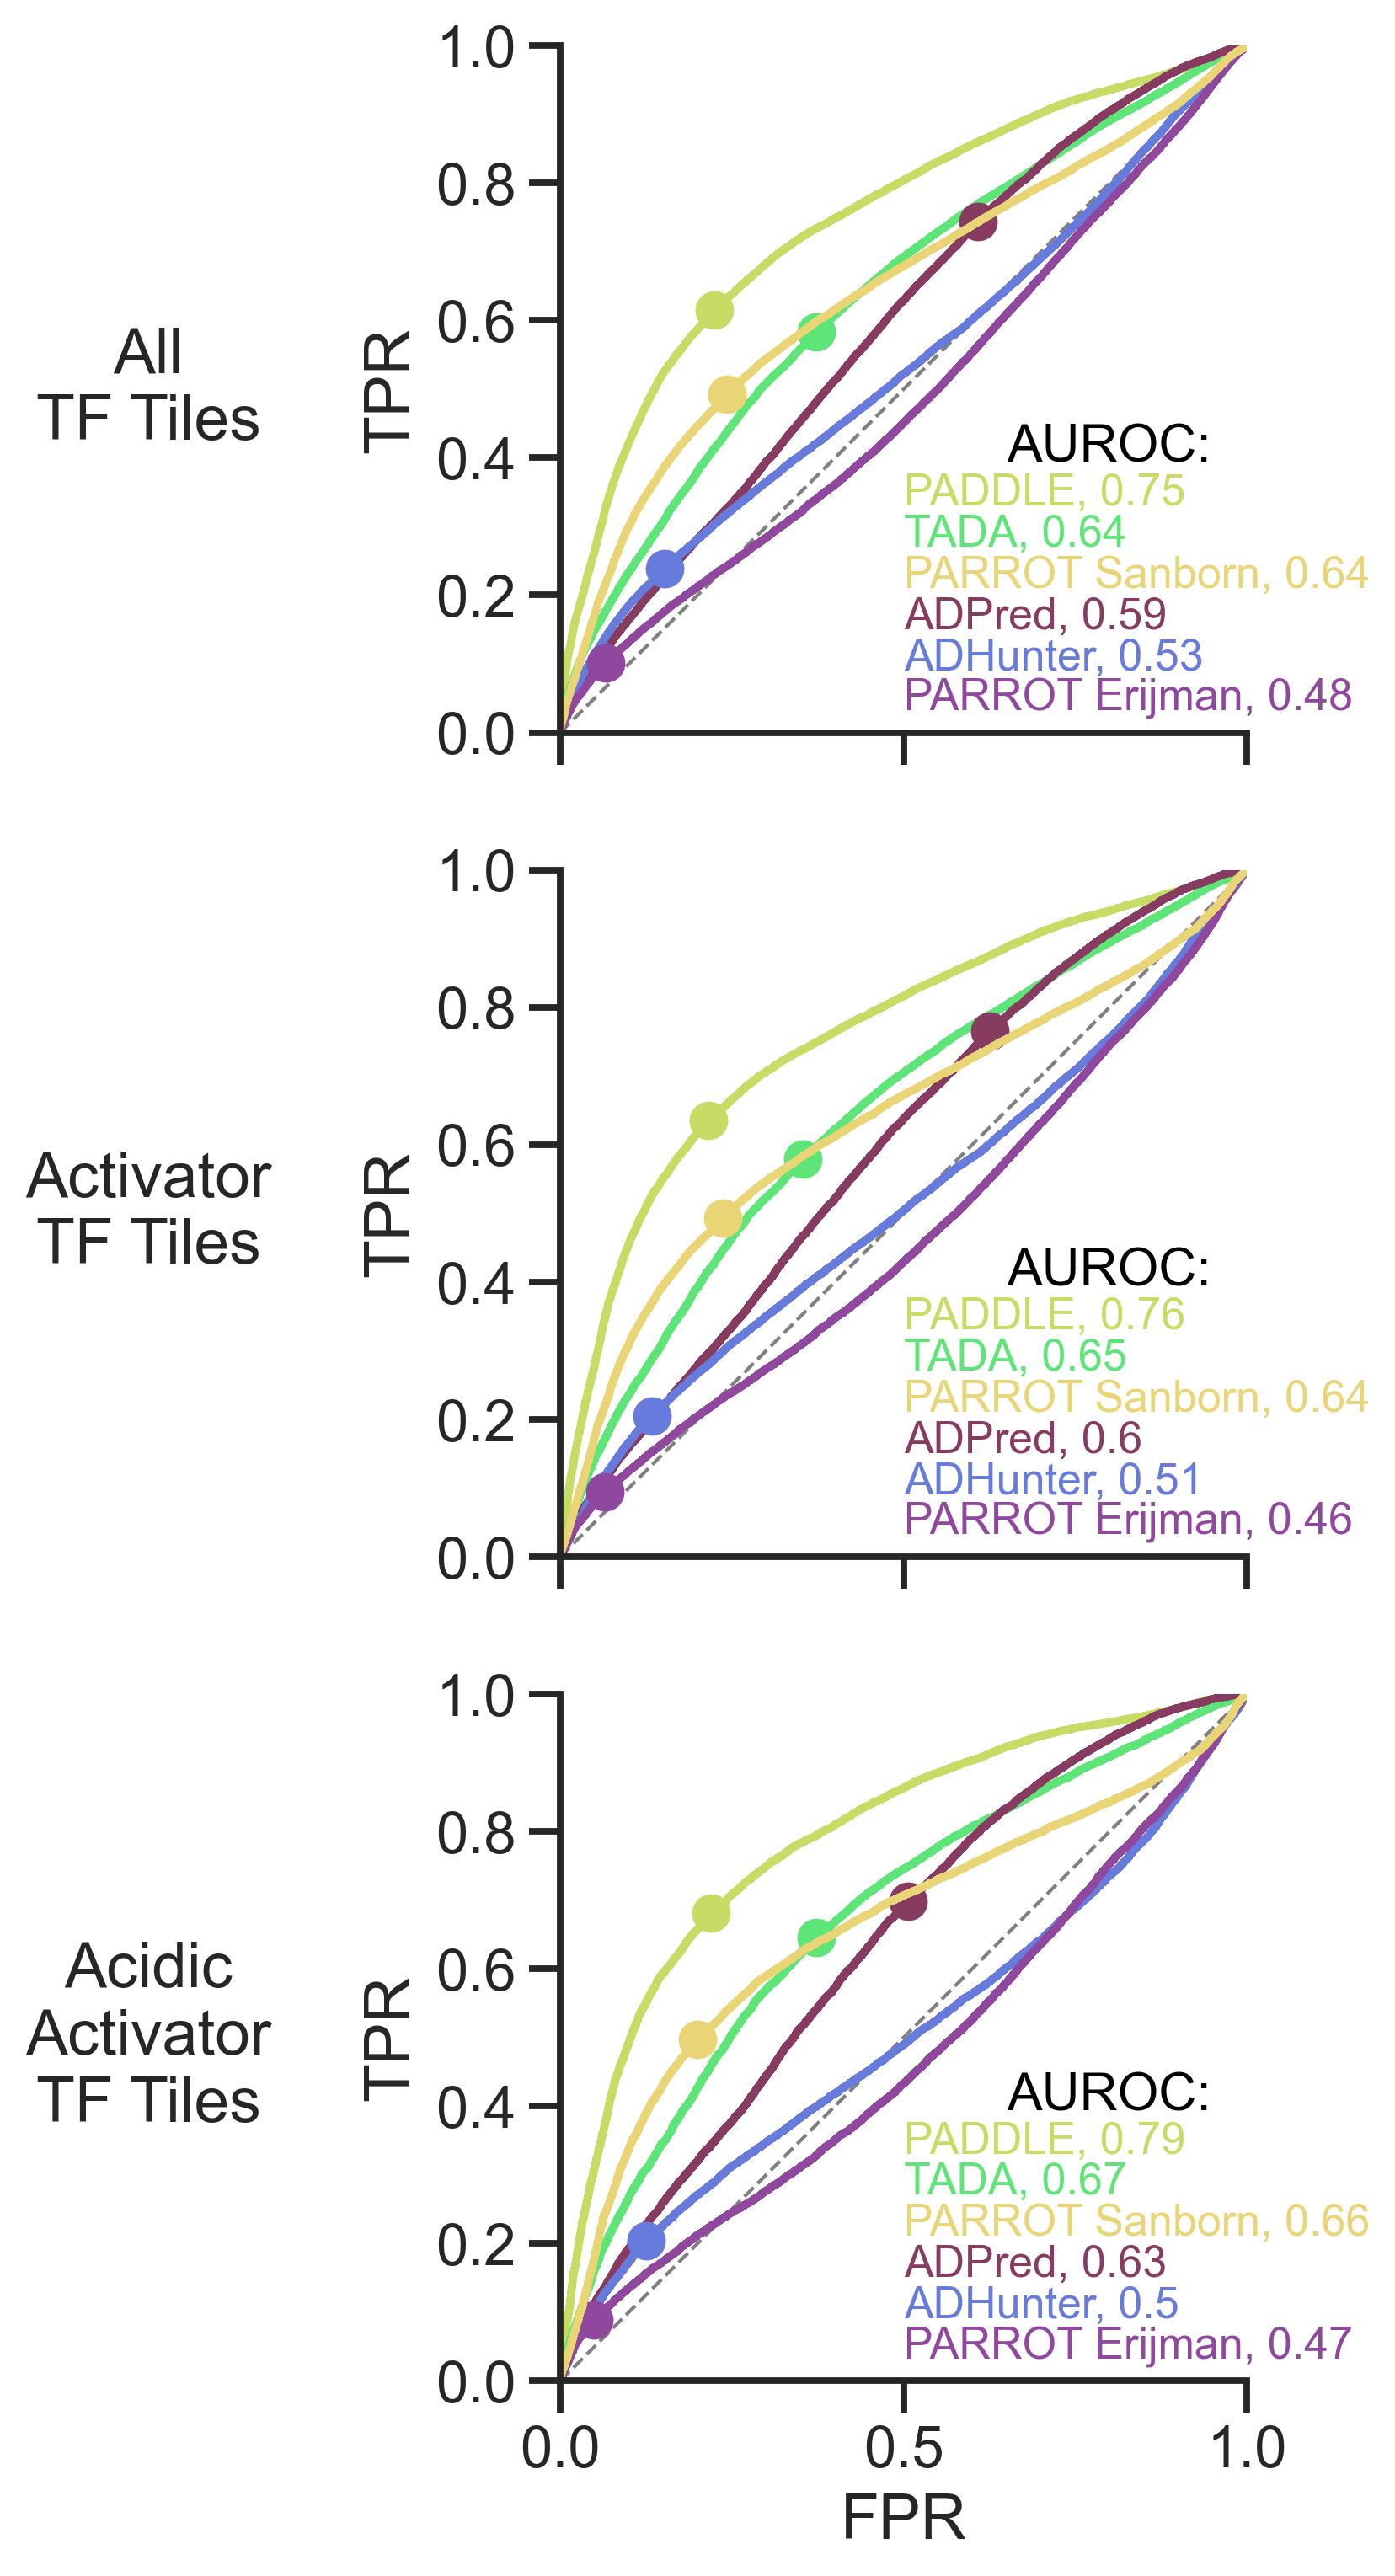

In [54]:
sns.set_context('talk')
fig, axs = plt.subplots(3,1, dpi=300, sharex = True, figsize = (6, 12))

# All TF tiles
plot_roc(paddle_processed,
            tada_processed,
            adpred_processed,
            adhunter_processed,
            parrot_erij_processed,
            parrot_paddle_processed,
            axs[0])
axs[0].text(s = "All\nTF Tiles", x = -0.6, y =0.5, ha = 'center', va = 'center', fontsize = 'medium')
axs[0].set_xlabel("")

# Only TFs ADs
filtered_paddle = paddle_processed[paddle_processed["uniprotID"].isin(known_ADs["uniprotID"])]
filtered_tada = tada_processed[tada_processed["uniprotID"].isin(known_ADs["uniprotID"])]
filtered_adpred = adpred_processed[adpred_processed["uniprotID"].isin(known_ADs["uniprotID"])]
filtered_adhunter = adhunter_processed[adhunter_processed["uniprotID"].isin(known_ADs["uniprotID"])]
filtered_parrot_erij = parrot_erij_processed[parrot_erij_processed["uniprotID"].isin(known_ADs["uniprotID"])]
filtered_parrot_paddle = parrot_paddle_processed[parrot_paddle_processed["uniprotID"].isin(known_ADs["uniprotID"])]

plot_roc(filtered_paddle,
         filtered_tada,
         filtered_adpred,
         filtered_adhunter,
         filtered_parrot_erij,
         filtered_parrot_paddle,
         axs[1])
#axs[1].set_title("Activator TF Tiles")
axs[1].text(s = "Activator\nTF Tiles", x = -0.6, y =0.5, ha = 'center', va = 'center', fontsize = 'medium')

axs[1].set_xlabel("")

# Only TFs acidic ADs
filtered_paddle = paddle_processed[paddle_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
filtered_tada = tada_processed[tada_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
filtered_adpred = adpred_processed[adpred_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
filtered_adhunter = adhunter_processed[adhunter_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
filtered_parrot_erij = parrot_erij_processed[parrot_erij_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
filtered_parrot_paddle = parrot_paddle_processed[parrot_paddle_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]

plot_roc(filtered_paddle,
         filtered_tada,
         filtered_adpred,
         filtered_adhunter,
         filtered_parrot_erij,
         filtered_parrot_paddle,
         axs[2])
# axs[2].set_title("Acidic Activator TF Tiles")
axs[2].text(s = "Acidic\nActivator\nTF Tiles", x = -0.6, y =0.5, ha = 'center', va = 'center', fontsize = 'medium')

#axs[2].set_xlabel("")


In [55]:
def plot_prc(paddle_processed,
             tada_processed,
             adpred_processed,
             adhunter_processed,
             parrot_erij_processed,
             parrot_paddle_processed,
             ax):

    paddle_auc = plot_AUPRC.plot_prc(paddle_processed, "preds", ax=ax,  color=colors["paddle"])
    tada_auc = plot_AUPRC.plot_prc(tada_processed, "tada", ax=ax,  color=colors["tada"])
    adpred_auc = plot_AUPRC.plot_prc(adpred_processed, "adpred", ax=ax,  color=colors["adpred"])
    adhunter_auc = plot_AUPRC.plot_prc(adhunter_processed, "adhunter", ax=ax,  color=colors["adhunter"])
    parrot_erij_auc = plot_AUPRC.plot_prc(parrot_erij_processed, "erij_pred", ax=ax,  color=colors["parrot_erij"])
    parrot_paddle_auc = plot_AUPRC.plot_prc(parrot_paddle_processed, "padd_pred", ax=ax,  color=colors["parrot_paddle"])

    paddle_random_expec = plot_AUPRC.plot_random_expec(paddle_processed, colors["paddle"], ax = ax)
    tada_random_expec = plot_AUPRC.plot_random_expec(tada_processed, colors["tada"], ax = ax)
    adpred_random_expec = plot_AUPRC.plot_random_expec(adpred_processed, colors["adpred"], ax = ax)
    adhunter_random_expec = plot_AUPRC.plot_random_expec(adhunter_processed, colors["adhunter"], ax = ax)
    parrot_erij_random_expec = plot_AUPRC.plot_random_expec(parrot_erij_processed, colors["parrot_erij"], ax = ax)
    parrot_paddle_random_expec = plot_AUPRC.plot_random_expec(parrot_paddle_processed, colors["parrot_paddle"], ax = ax)

    ax.text(x = 0.75, y = 1, s = "AUPRC - Prevalence:", ha = "left", va = "top", fontsize = "small")
    ax.text(x = 0.9, y = 0.92, s = "PADDLE, " + str(round(paddle_auc, 2)),
                        color = colors["paddle"], ha = "left", va = "top", fontsize = "x-small")
    ax.text(x = 0.9, y = 0.86, s = "TADA, " + str(round(tada_auc, 2)), 
                        color = colors["tada"], ha = "left", va = "top", fontsize = "x-small")
    ax.text(x = 0.9, y = 0.80, s = "PARROT PADDLE, " + str(round(parrot_paddle_auc, 2)), 
                        color = colors["parrot_paddle"], ha = "left", va = "top", fontsize = "x-small")
    ax.text(x = 0.9, y = 0.74, s = "ADPred, " + str(round(adpred_auc, 2)), 
                        color = colors["adpred"], ha = "left", va = "top", fontsize = "x-small")
    ax.text(x = 0.9, y = 0.68, s = "ADHunter, " + str(round(adhunter_auc, 2)), 
                        color = colors["adhunter"], ha = "left", va = "top", fontsize = "x-small")
    ax.text(x = 0.9, y = 0.62, s = "PARROT Erij, " + str(round(parrot_erij_auc, 2)), 
                        color = colors["parrot_erij"], ha = "left", va = "top", fontsize = "x-small")


In [56]:
parrot_erij_auc

NameError: name 'parrot_erij_auc' is not defined

In [57]:
plot_AUPRC.plot_random_expec(filtered_parrot_erij, colors["parrot_erij"], ax = ax)

0.5079375013037946

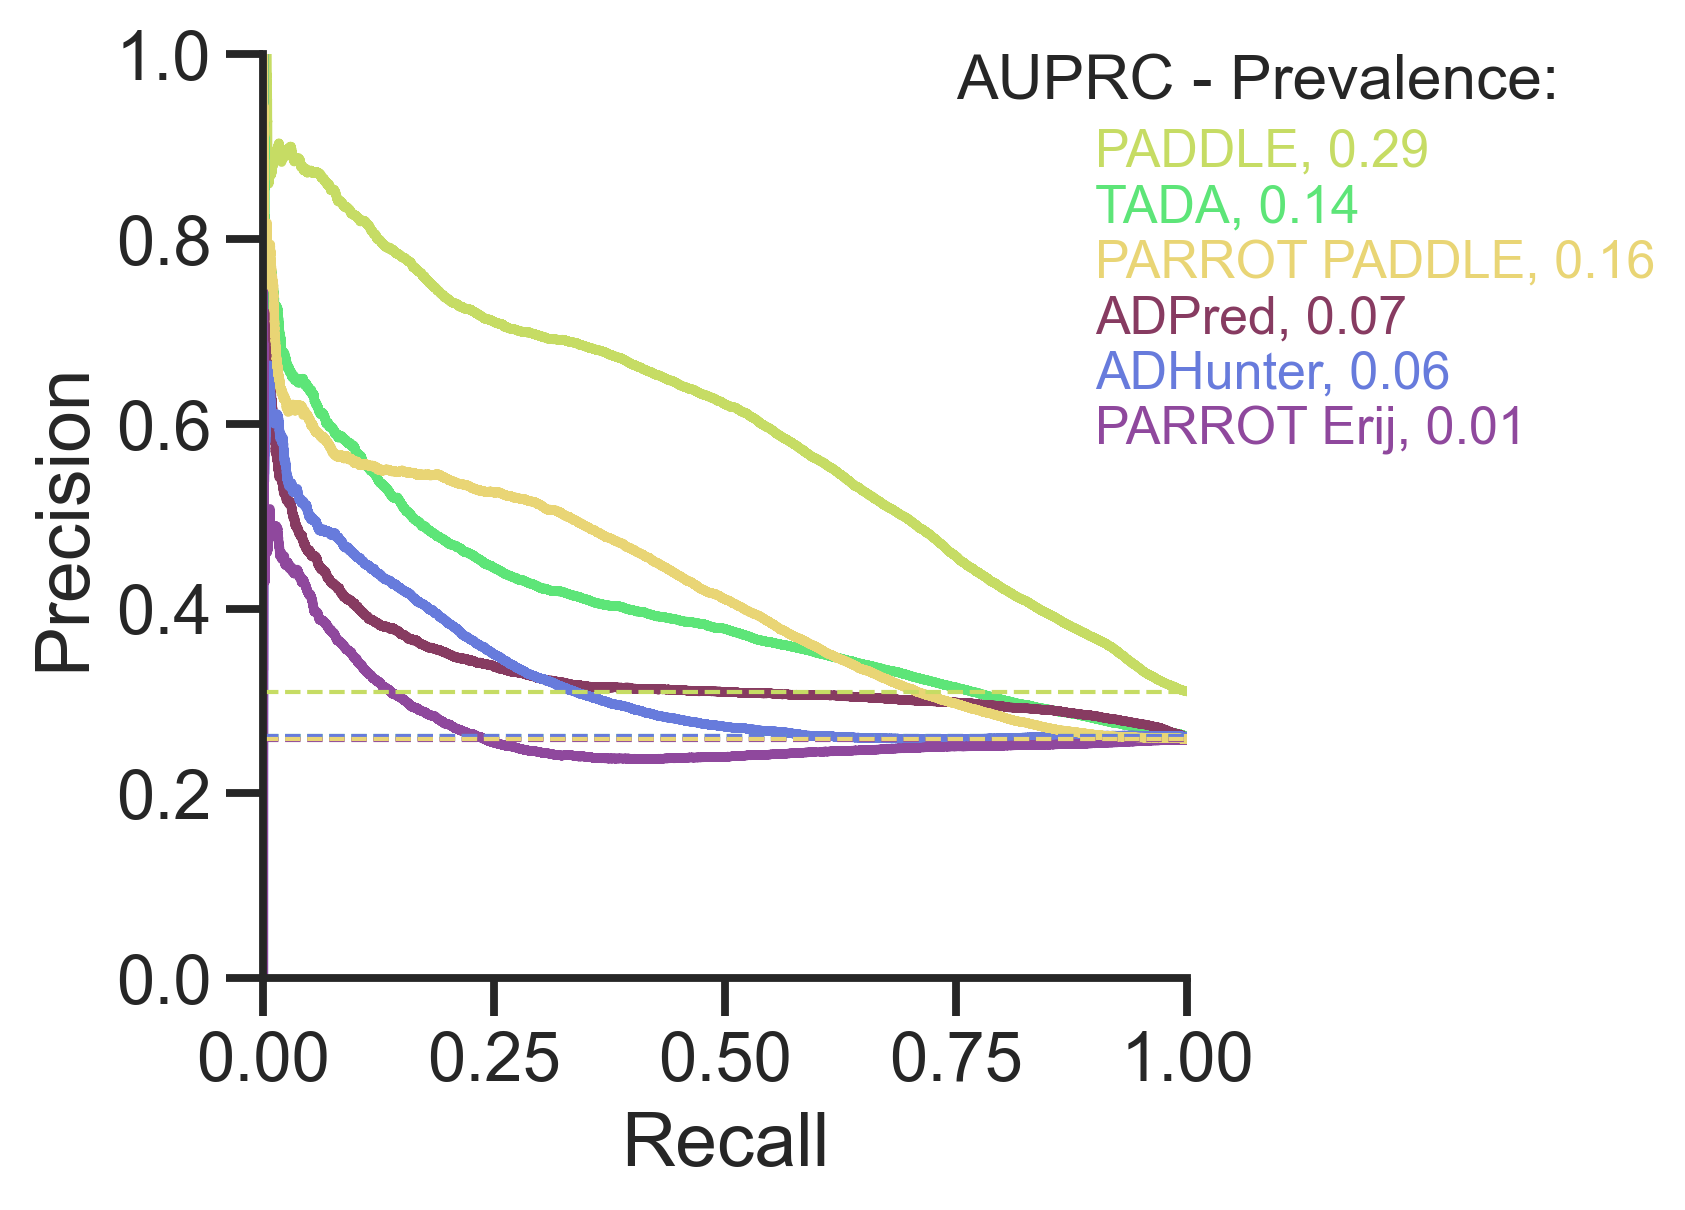

In [58]:
fig,ax = plt.subplots()
plot_prc(paddle_processed,
            tada_processed,
            adpred_processed,
            adhunter_processed,
            parrot_erij_processed,
            parrot_paddle_processed, ax)

Text(-0.6, 0.5, 'Acidic\nActivator\nTF Tiles')

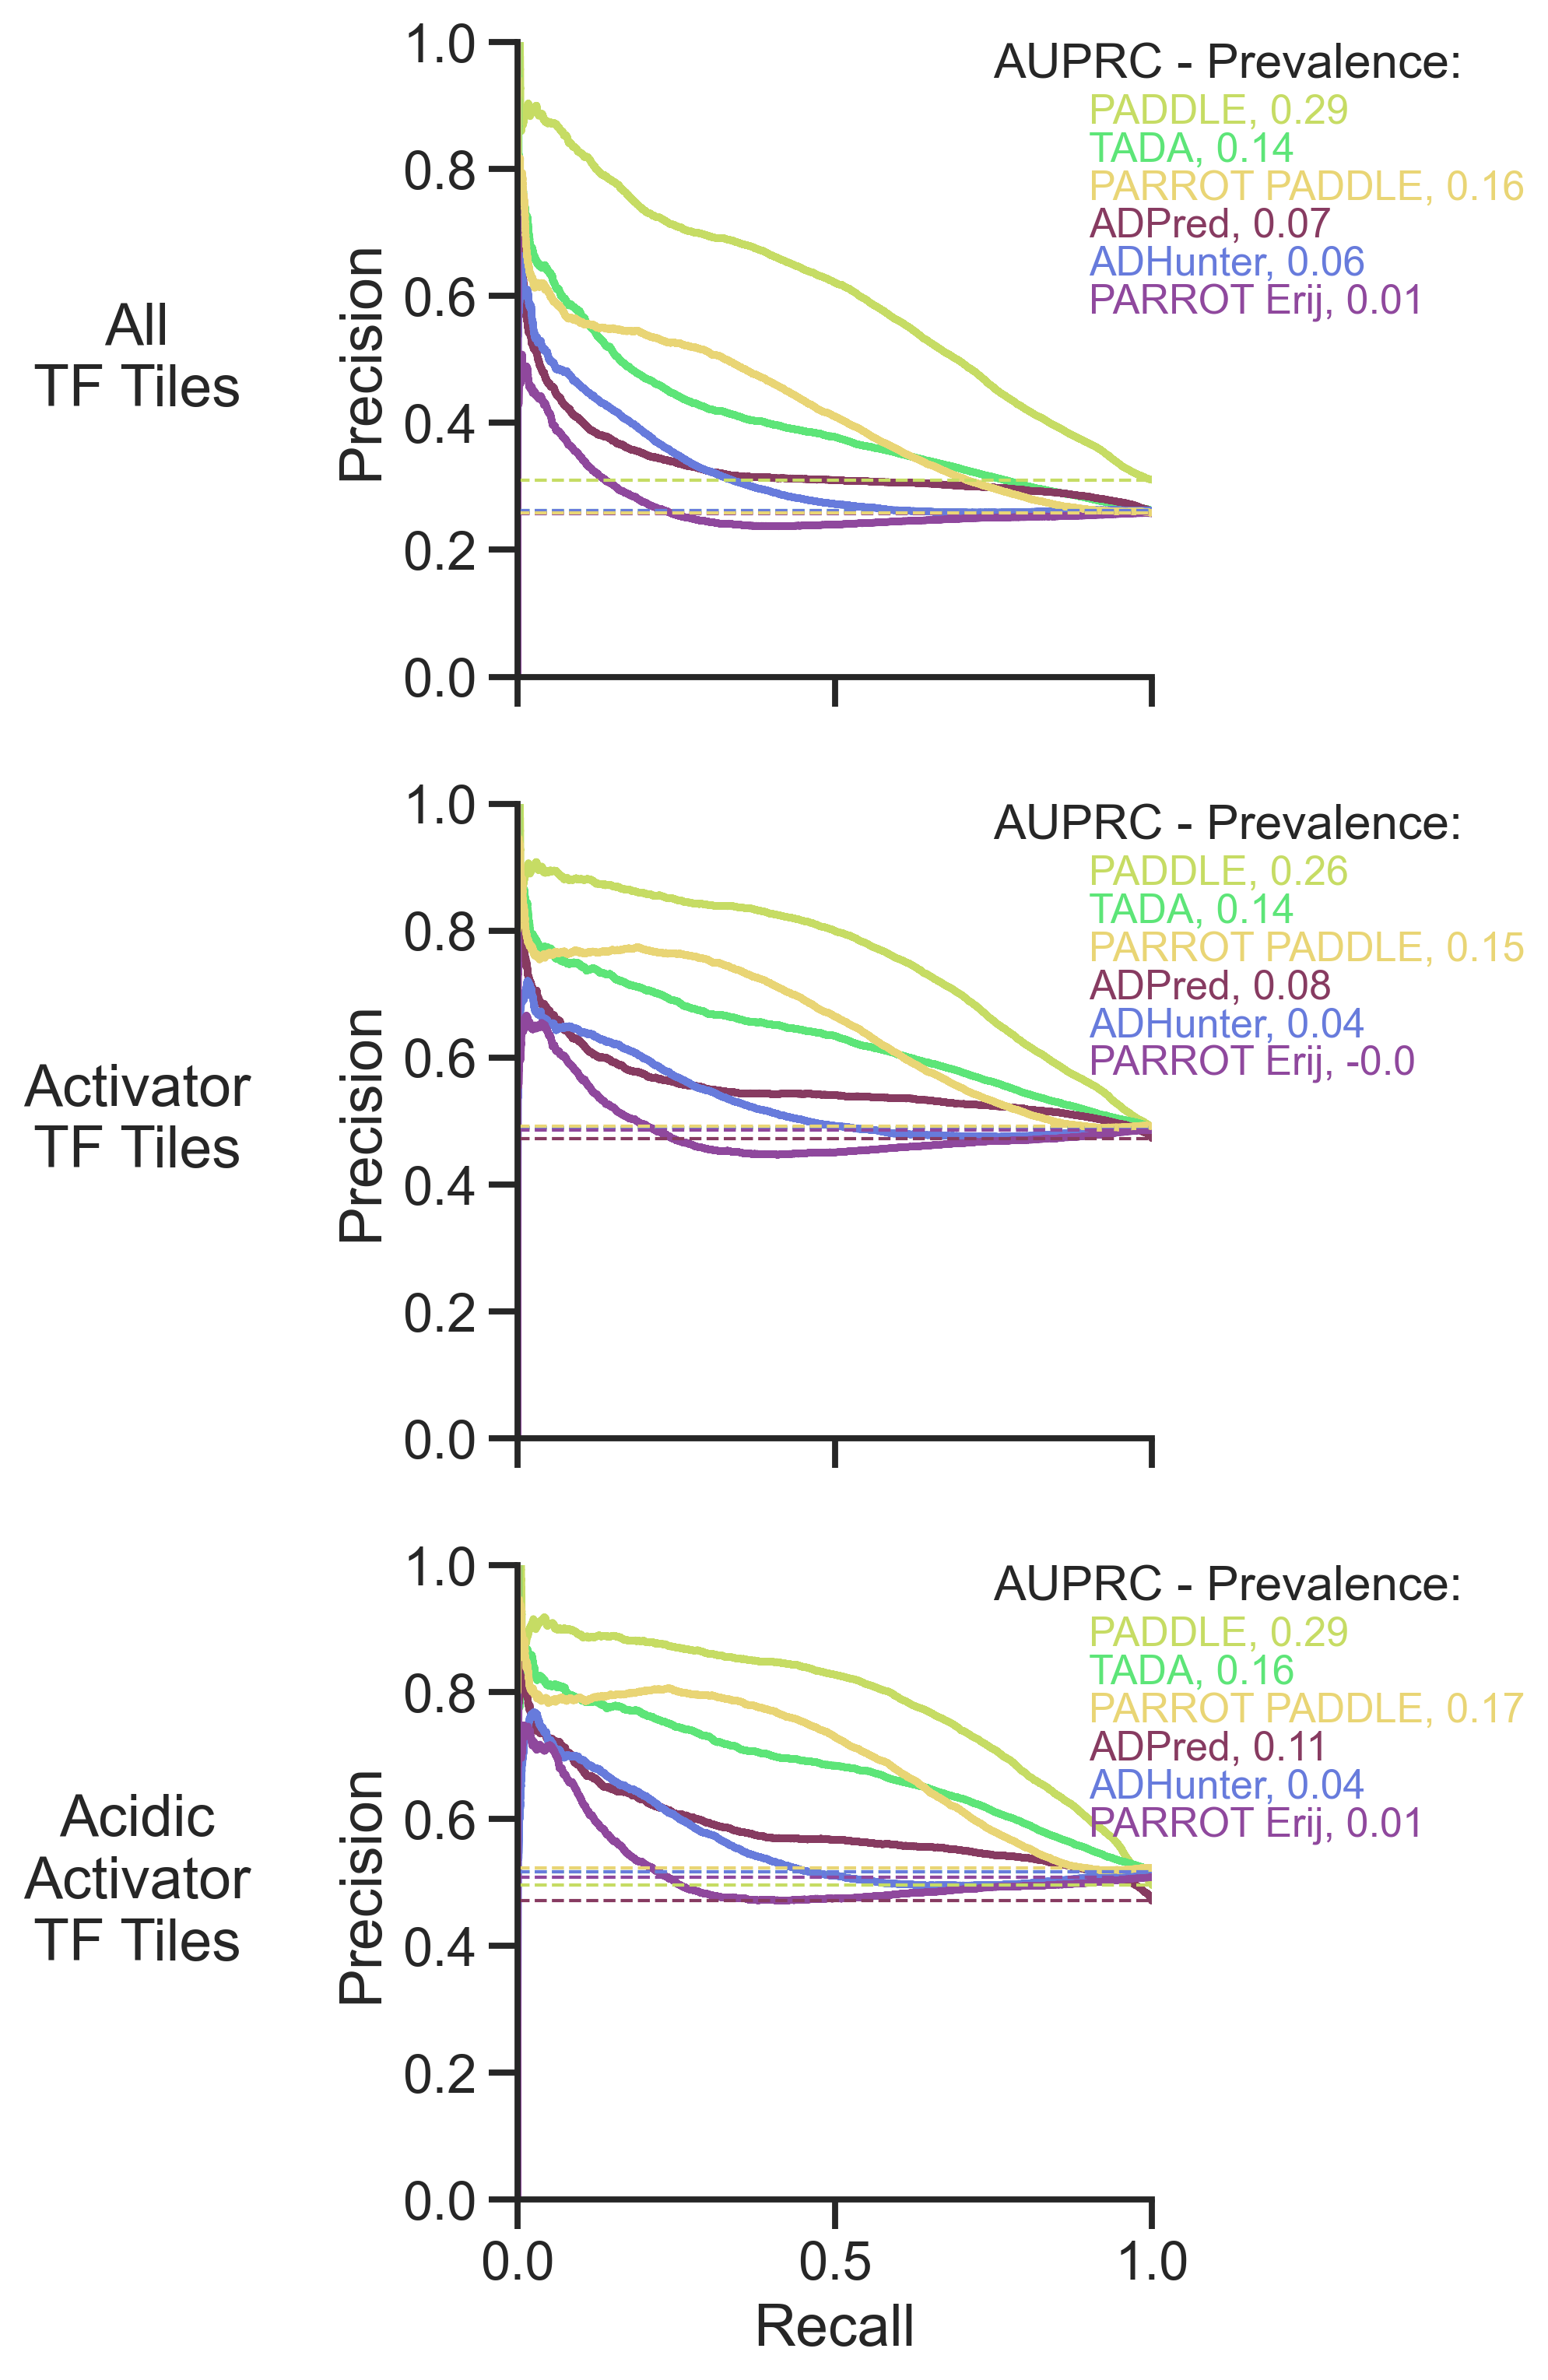

In [59]:
sns.set_context('talk')
fig, axs = plt.subplots(3,1, dpi=300, sharex = True, figsize = (6, 12))

# All TF tiles
plot_prc(paddle_processed,
            tada_processed,
            adpred_processed,
            adhunter_processed,
            parrot_erij_processed,
            parrot_paddle_processed,
            axs[0])
axs[0].text(s = "All\nTF Tiles", x = -0.6, y =0.5, ha = 'center', va = 'center', fontsize = 'medium')
axs[0].set_xlabel("")

# Only TFs ADs
filtered_paddle = paddle_processed[paddle_processed["uniprotID"].isin(known_ADs["uniprotID"])]
filtered_tada = tada_processed[tada_processed["uniprotID"].isin(known_ADs["uniprotID"])]
filtered_adpred = adpred_processed[adpred_processed["uniprotID"].isin(known_ADs["uniprotID"])]
filtered_adhunter = adhunter_processed[adhunter_processed["uniprotID"].isin(known_ADs["uniprotID"])]
filtered_parrot_erij = parrot_erij_processed[parrot_erij_processed["uniprotID"].isin(known_ADs["uniprotID"])]
filtered_parrot_paddle = parrot_paddle_processed[parrot_paddle_processed["uniprotID"].isin(known_ADs["uniprotID"])]

plot_prc(filtered_paddle,
         filtered_tada,
         filtered_adpred,
         filtered_adhunter,
         filtered_parrot_erij,
         filtered_parrot_paddle,
         axs[1])
#axs[1].set_title("Activator TF Tiles")
axs[1].text(s = "Activator\nTF Tiles", x = -0.6, y =0.5, ha = 'center', va = 'center', fontsize = 'medium')

axs[1].set_xlabel("")

# Only TFs acidic ADs
filtered_paddle = paddle_processed[paddle_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
filtered_tada = tada_processed[tada_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
filtered_adpred = adpred_processed[adpred_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
filtered_adhunter = adhunter_processed[adhunter_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
filtered_parrot_erij = parrot_erij_processed[parrot_erij_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
filtered_parrot_paddle = parrot_paddle_processed[parrot_paddle_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]

plot_prc(filtered_paddle,
         filtered_tada,
         filtered_adpred,
         filtered_adhunter,
         filtered_parrot_erij,
         filtered_parrot_paddle,
         axs[2])
# axs[2].set_title("Acidic Activator TF Tiles")
axs[2].text(s = "Acidic\nActivator\nTF Tiles", x = -0.6, y =0.5, ha = 'center', va = 'center', fontsize = 'medium')

#axs[2].set_xlabel("")


Best threshold for preds:0.20094086
0.05128286751130069 0.003320689901953768

Best threshold for tada:0.1841165
Best threshold for adpred:0.00124123215
Best threshold for adhunter:56588.035
Best threshold for erij_pred:0.15307611
Best threshold for padd_pred:0.24649987
Best threshold for preds:0.17586028
0.05133025330571929 0.005780346820809248

Best threshold for tada:0.18453944
Best threshold for adpred:0.00104797597
Best threshold for adhunter:59645.086
Best threshold for erij_pred:0.17256586
Best threshold for padd_pred:0.24656086
Best threshold for preds:0.19516232
0.07336702227213177 0.007943067033976126

Best threshold for tada:0.18291214
Best threshold for adpred:0.00238765217
Best threshold for adhunter:60805.043
Best threshold for erij_pred:0.281502
Best threshold for padd_pred:0.31931672


Text(0.5, 1.03, 'Lambert TF Predictor Performance')

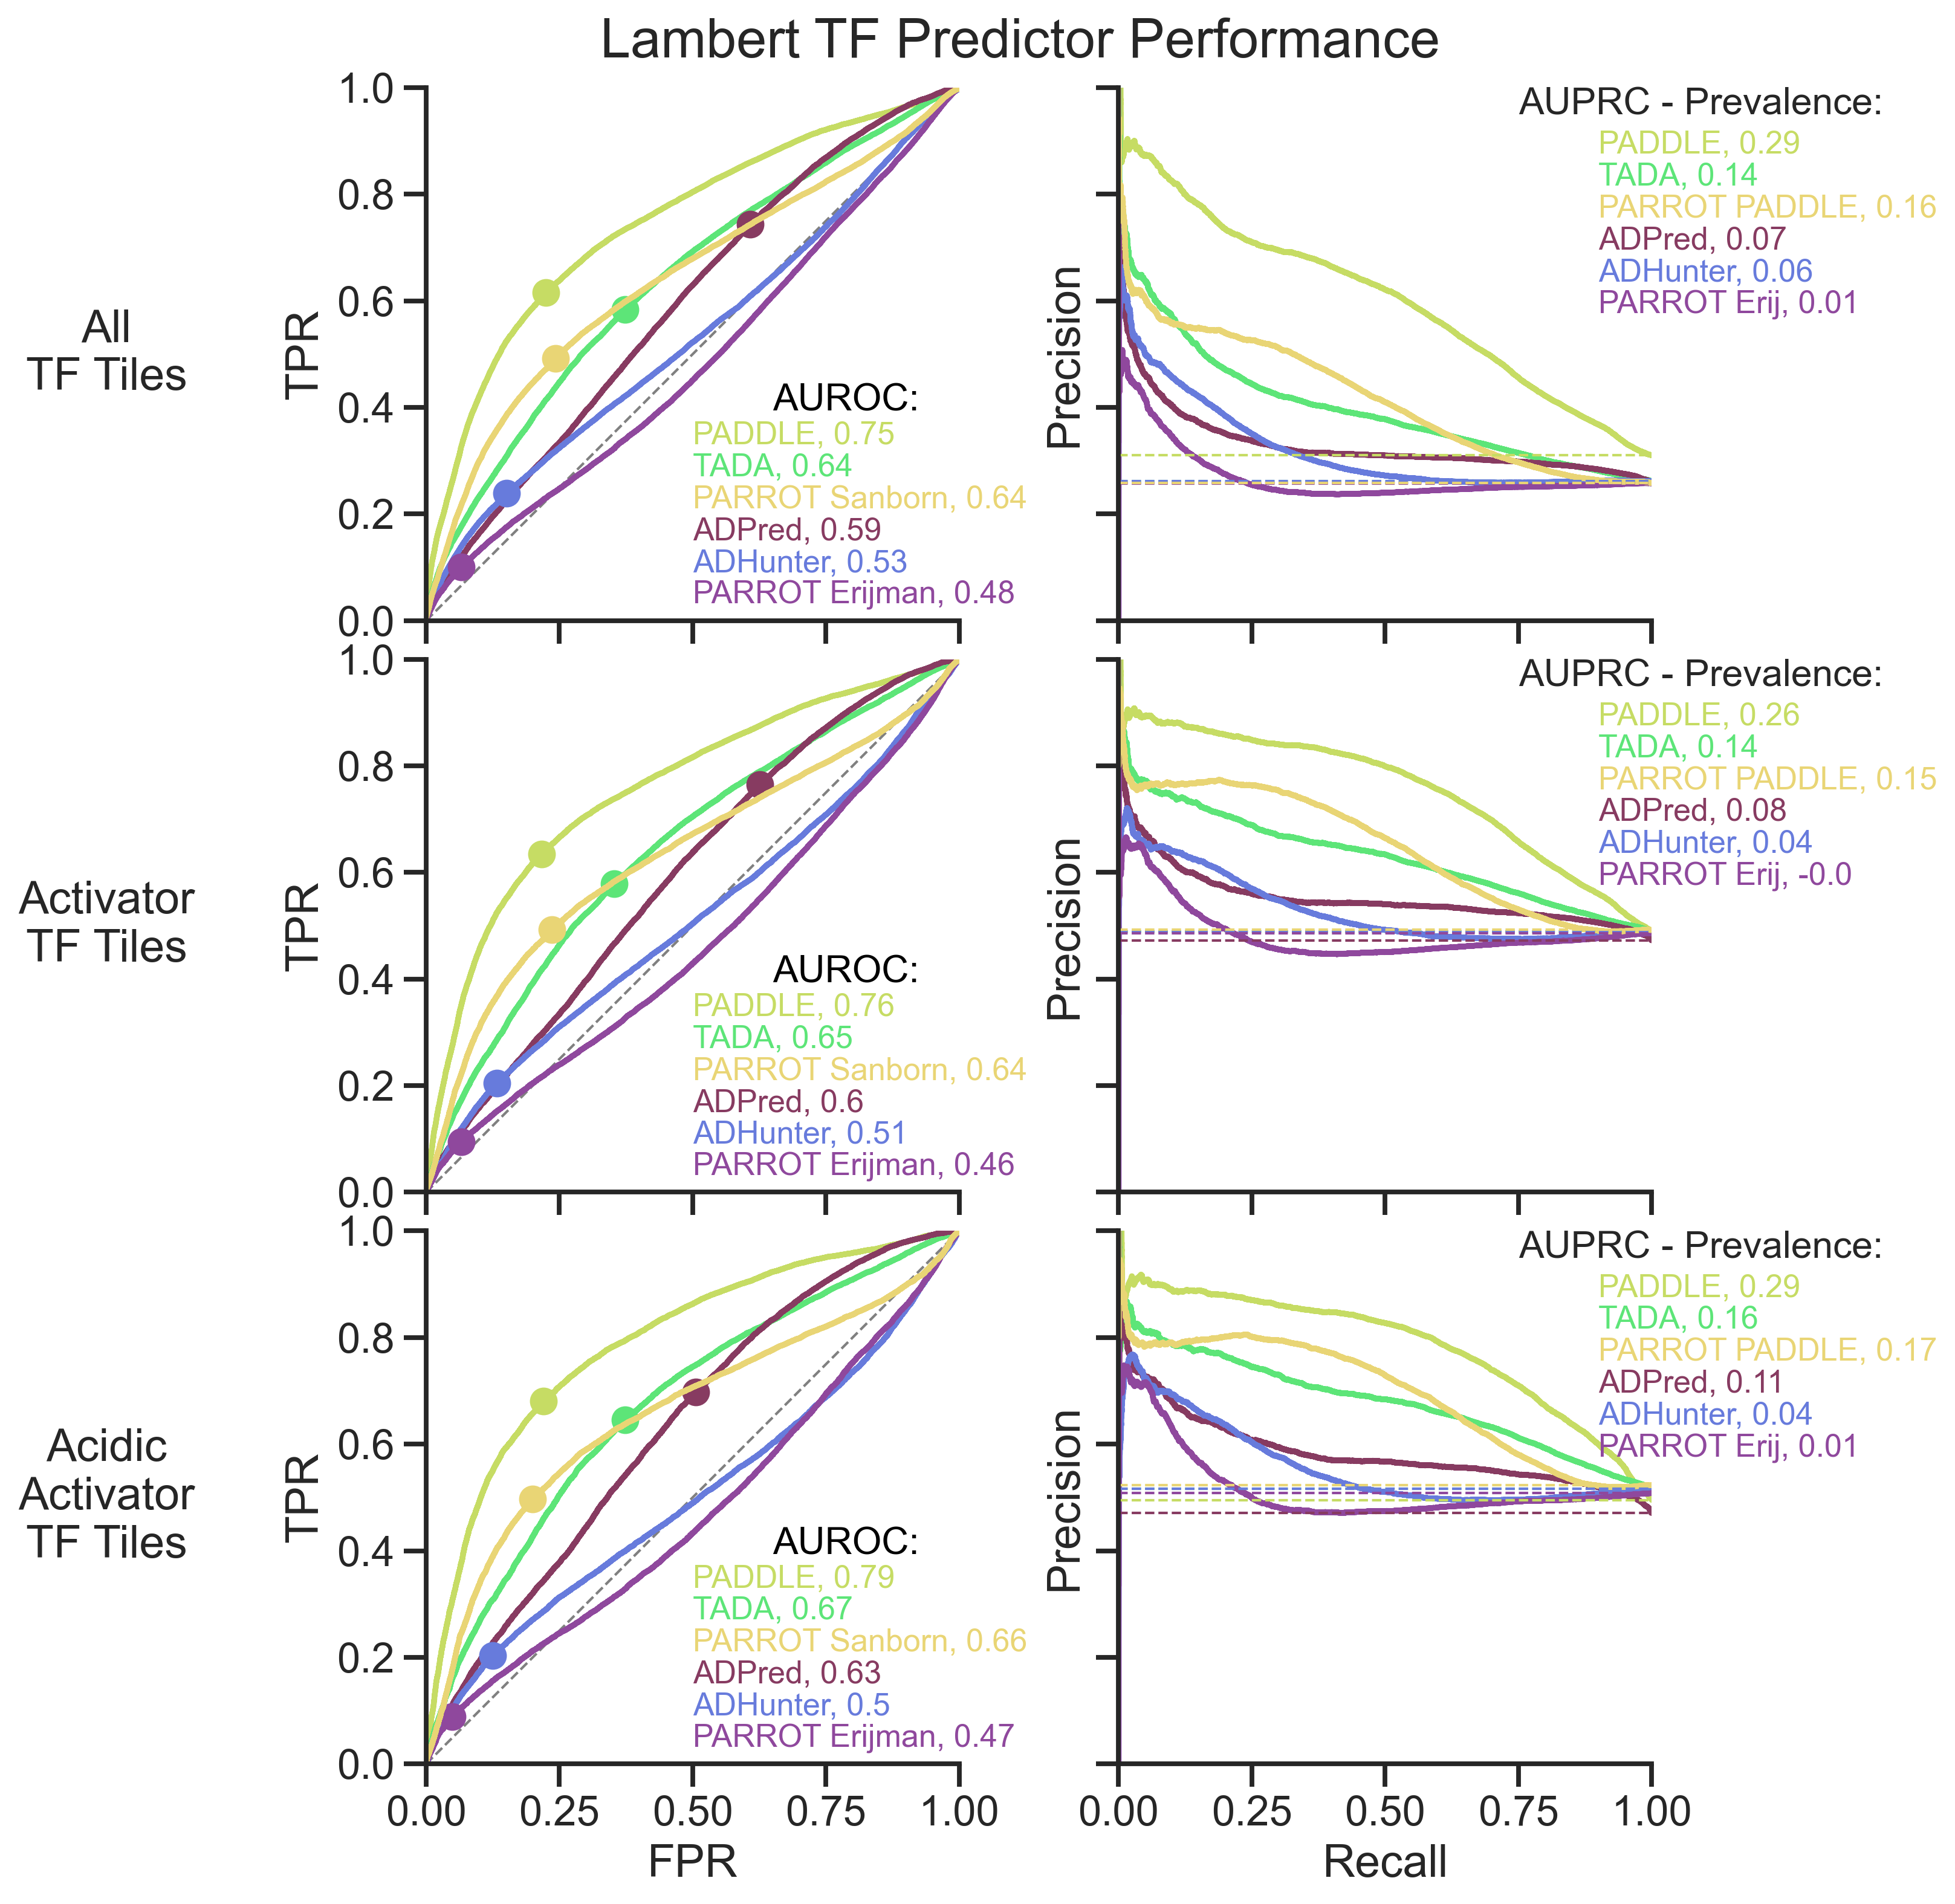

In [60]:
sns.set_context('talk')
sns.set_style('ticks')

fig, axs = plt.subplots(3,2, dpi=300, sharex = True, sharey = True, figsize = (10,10))
axs = axs.flatten()

# All TF tiles
plot_roc(paddle_processed,
            tada_processed,
            adpred_processed,
            adhunter_processed,
            parrot_erij_processed,
            parrot_paddle_processed,
            axs[0])
axs[0].text(s = "All\nTF Tiles", x = -0.6, y =0.5, ha = 'center', va = 'center', fontsize = 'medium')
axs[0].set_xlabel("")

# Only TFs ADs
filtered_paddle = paddle_processed[paddle_processed["uniprotID"].isin(known_ADs["uniprotID"])]
filtered_tada = tada_processed[tada_processed["uniprotID"].isin(known_ADs["uniprotID"])]
filtered_adpred = adpred_processed[adpred_processed["uniprotID"].isin(known_ADs["uniprotID"])]
filtered_adhunter = adhunter_processed[adhunter_processed["uniprotID"].isin(known_ADs["uniprotID"])]
filtered_parrot_erij = parrot_erij_processed[parrot_erij_processed["uniprotID"].isin(known_ADs["uniprotID"])]
filtered_parrot_paddle = parrot_paddle_processed[parrot_paddle_processed["uniprotID"].isin(known_ADs["uniprotID"])]

plot_roc(filtered_paddle,
         filtered_tada,
         filtered_adpred,
         filtered_adhunter,
         filtered_parrot_erij,
         filtered_parrot_paddle,
         axs[2])
#axs[1].set_title("Activator TF Tiles")
axs[2].text(s = "Activator\nTF Tiles", x = -0.6, y =0.5, ha = 'center', va = 'center', fontsize = 'medium')

axs[2].set_xlabel("")

# Only TFs acidic ADs
filtered_paddle = paddle_processed[paddle_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
filtered_tada = tada_processed[tada_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
filtered_adpred = adpred_processed[adpred_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
filtered_adhunter = adhunter_processed[adhunter_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
filtered_parrot_erij = parrot_erij_processed[parrot_erij_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
filtered_parrot_paddle = parrot_paddle_processed[parrot_paddle_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]

plot_roc(filtered_paddle,
         filtered_tada,
         filtered_adpred,
         filtered_adhunter,
         filtered_parrot_erij,
         filtered_parrot_paddle,
         axs[4])
# axs[2].set_title("Acidic Activator TF Tiles")
axs[4].text(s = "Acidic\nActivator\nTF Tiles", x = -0.6, y =0.5, ha = 'center', va = 'center', fontsize = 'medium')

#axs[4].set_xlabel("")


# All TF tiles
plot_prc(paddle_processed,
            tada_processed,
            adpred_processed,
            adhunter_processed,
            parrot_erij_processed,
            parrot_paddle_processed,
            axs[1])
axs[1].set_xlabel("")

# Only TFs ADs
filtered_paddle = paddle_processed[paddle_processed["uniprotID"].isin(known_ADs["uniprotID"])]
filtered_tada = tada_processed[tada_processed["uniprotID"].isin(known_ADs["uniprotID"])]
filtered_adpred = adpred_processed[adpred_processed["uniprotID"].isin(known_ADs["uniprotID"])]
filtered_adhunter = adhunter_processed[adhunter_processed["uniprotID"].isin(known_ADs["uniprotID"])]
filtered_parrot_erij = parrot_erij_processed[parrot_erij_processed["uniprotID"].isin(known_ADs["uniprotID"])]
filtered_parrot_paddle = parrot_paddle_processed[parrot_paddle_processed["uniprotID"].isin(known_ADs["uniprotID"])]

plot_prc(filtered_paddle,
         filtered_tada,
         filtered_adpred,
         filtered_adhunter,
         filtered_parrot_erij,
         filtered_parrot_paddle,
         axs[3])
#axs[1].set_title("Activator TF Tiles")
    
axs[3].set_xlabel("")

# Only TFs acidic ADs
filtered_paddle = paddle_processed[paddle_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
filtered_tada = tada_processed[tada_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
filtered_adpred = adpred_processed[adpred_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
filtered_adhunter = adhunter_processed[adhunter_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
filtered_parrot_erij = parrot_erij_processed[parrot_erij_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
filtered_parrot_paddle = parrot_paddle_processed[parrot_paddle_processed["uniprotID"].isin(acidic_known_ADs["uniprotID"])]

plot_prc(filtered_paddle,
         filtered_tada,
         filtered_adpred,
         filtered_adhunter,
         filtered_parrot_erij,
         filtered_parrot_paddle,
         axs[5])

plt.tight_layout(pad = 0)
plt.suptitle("Lambert TF Predictor Performance", y = 1.03)
# axs[2].set_title("Acidic Activator TF Tiles")

#axs[2].set_xlabel("")

# Now, summary table

### 1. Limiting human TFs to those containing at least one annotated acidic activation domain


In [481]:
lambert_TFs = pd.read_csv("../../SFARI/output/lambert_TFs_10-21-24_with_DBD_coords.csv")
lambert_TFs["uniprotID"] = lambert_TFs["id"].str.split("|").str[1]
lambert_TFs

,Unnamed: 0,id,ProteinSeq,DBD_coords_merged,uniprotID
0,0,sp|A0A087WUV0|ZN892_HUMAN Zinc finger protein ...,MEPEGRGSLFEDSDLLHAGNPKENDVTAVLLTPGSQELMIRDMAEA...,"[[221, 243], [249, 271], [277, 299], [305, 327...",A0A087WUV0
1,1,sp|A0AVK6|E2F8_HUMAN Transcription factor E2F8...,MENEKENLFCEPHKRGLMKTPLKESTTANIVLAEIQPDFGPLTTPT...,"[[114, 182], [262, 347]]",A0AVK6
2,2,sp|A0PJY2|FEZF1_HUMAN Fez family zinc finger p...,MDSSCHNATTKMLATAPARGNMMSTSKPLAFSIERIMARTPEPKAL...,"[[260, 282], [288, 310], [316, 338], [344, 366...",A0PJY2
3,3,sp|A1A519|F170A_HUMAN Protein FAM170A OS=Homo ...,MKRRQKRKHLENEESQETAEKGGGMSKSQEDALQPGSTRVAKGWSQ...,"[[1, 330]]",A1A519
4,4,sp|A1YPR0|ZBT7C_HUMAN Zinc finger and BTB doma...,MANDIDELIGIPFPNHSSEVLCSLNEQRHDGLLCDVLLVVQEQEYR...,"[[364, 386], [392, 414], [420, 442], [448, 469]]",A1YPR0
...,...,...,...,...,...
1608,1608,sp|Q9Y6Q9|NCOA3_HUMAN Nuclear receptor coactiv...,MSGLGENLDPLASDSRKRKLPCDTPGQGLTCSGEKRRREQESKYIE...,"[[31, 83]]",Q9Y6Q9
1609,1609,sp|Q9Y6R6|Z780B_HUMAN Zinc finger protein 780B...,MVHGSVTFRDVAIDFSQEEWECLQPDQRTLYRDVMLENYSHLISLG...,"[[165, 187], [193, 215], [221, 243], [249, 271...",Q9Y6R6
1610,1610,sp|Q9Y6X0|SETBP_HUMAN SET-binding protein OS=H...,MESRETLSSSRQRGGESDFLPVSSAKPPAAPGCAGEPLLSTPGPGK...,"[[583, 596], [1015, 1027], [1450, 1462]]",Q9Y6X0
1611,1611,sp|Q9Y6X8|ZHX2_HUMAN Zinc fingers and homeobox...,MASKRKSTTPCMVRTSQVVEQDVPEEVDRAKEKGIGTPQPDVAKDS...,"[[78, 101], [110, 133], [271, 317], [442, 496]...",Q9Y6X8


,Unnamed: 0,Gene,Start,End,uniprotID,Matching Isoforms,Canonical Transcript ID,orig_uniprotID,Reference,TileType,ProteinRegionSeq,charge
3,3,AHR,532,848,P35869,"[['P35869'], ['P35869'], ['P35869']]",ENST00000242057 / nan / ENST00000242057,P35869 / P35869 / P35869,"DelRosso et al. (P35869, 532_641) // PMID: 879...",TF / TF / TF,QDSKNSDLYSIMKNLGIDFEDIRHMQNEKFFRNDFSGEVDFRDIDL...,-20
5,5,AKAP8L,1,384,Q9ULX6,"[['Q9ULX6'], ['Q9ULX6'], ['Q9ULX6']]",nan / nan / ENST00000397410,Q9ULX6 / Q9ULX6 / Q9ULX6,"PMID: 11402034, Soto (Q9ULX6, 1_384) // activa...",TF / TF / TF,MSYTGFVQGSETTLQSTYSDTSAQPTCDYGYGTWNSGTNRGYEGYG...,-13
7,7,ARGFX,142,315,A6NJG6,"[['A6NJG6'], ['A6NJG6']]",ENST00000334384 / ENST00000334384,A6NJG6 / A6NJG6,"DelRosso et al. (A6NJG6, 142_251) // DelRosso ...",TF / TF,AKQRNQILPSKKNVPTSPRTSPSPYAFSPVISDFYSSLPSQPLDPS...,-8
8,8,ARNTL,543,626,O00327,"[['O00327-8'], ['O00327']]",ENST00000389707 / nan,O00327 / O00327,"DelRosso et al. (O00327-8, 542_625) // PMID: 1...",TF / TF,GGTPDIPSSGLLSGQAQENPGYPYSDSSSILGENPHIGIDMIDNDQ...,-13
9,9,BMAL2 / ARNTL2,542,636,Q8WYA1,"[['Q8WYA1'], ['Q8WYA1']]",ENST00000266503 / nan,Q8WYA1 / Q8WYA1,"DelRosso et al. (Q8WYA1, 542_636) // Staller A...",TF / TF,TGLMKDTHTVNCRSMSNKELFPPSPSEMGELEATRQNQSTVAVHSH...,-13
...,...,...,...,...,...,...,...,...,...,...,...,...
729,730,MEIS2,340,477,O14770,[['O14770']],NaN,O14770,"activation_regions.txt, GSL (O14770, 340_477)",TF,DQSNRAGFLLDPSVSQGAAYSPEGQPMGSFVLDGQQHMGIRPAGLQ...,-4
735,736,CEBPB,24,124,P17676,[['P17676']],NaN,P17676,"Choi 2000 list, GSL (P17676, 24_124)",TF,MEVANFYYEADCLAAAYGGKAAPAAPPAARPGPRPPAGELGSIGDH...,-9
737,738,TFEB,156,165,P19484,[['P19484']],NaN,P19484,"activation_regions.txt, GSL (P19484, 156_165)",TF,ELDDVIDNIM,-4
740,741,ZXDB,576,703,P98169,[['P98169']],NaN,P98169 / P98169,"R4TA_regions.txt / activation_regions.txt, GSL...",TF,QDLLAQLEAANSLTPSSELTSQRQNDLSDAEIVSLFSDVPDSTSAA...,-14


In [483]:
# Only keep lambert TFs within acidic known ADs
TF_subset = lambert_TFs[lambert_TFs["uniprotID"].isin(acidic_known_ADs["uniprotID"])]
TF_subset

,Unnamed: 0,id,ProteinSeq,DBD_coords_merged,uniprotID
17,17,sp|A6NJG6|ARGFX_HUMAN Arginine-fifty homeobox ...,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSG...,"[[79, 135]]",A6NJG6
40,40,sp|A8MYZ6|FOXO6_HUMAN Forkhead box protein O6 ...,MAAKLRAHQVDVDPDFAPQSRPRSCTWPLPQPDLAGDEDGALGAGV...,"[[89, 178]]",A8MYZ6
41,41,sp|A8MZ59|LEUTX_HUMAN Paired-like homeodomain ...,MFEGPRRYRRPRTRFLSKQLTALRELLEKTMHPSLATMGKLASKLQ...,"[[31, 65]]",A8MZ59
53,53,sp|O00321|ETV2_HUMAN ETS translocation variant...,MDLWNWDEASPQEVPPGNKLAGLEGAKLGFCFPDLALQGDTPTATA...,"[[242, 321]]",O00321
54,54,sp|O00327|BMAL1_HUMAN Basic helix-loop-helix A...,MADQRMDISSTISDFMSPGPTDLLSSSLGTSGVDCNRKRKGSSTDY...,"[[73, 126]]",O00327
...,...,...,...,...,...
1598,1598,sp|Q9Y5Q3|MAFB_HUMAN Transcription factor MafB...,MAAELSMGPELPTSPLAMEYVNDFDLLKFDVKKEPLGRAERPGRPC...,"[[237, 302]]",Q9Y5Q3
1600,1600,sp|Q9Y5R6|DMRT1_HUMAN Doublesex- and mab-3-rel...,MPNDEAFSKPSTPSEAPHAPGVPPQGRAGGFGKASGALVGAASGSS...,"[[72, 118]]",Q9Y5R6
1602,1602,sp|Q9Y5W3|KLF2_HUMAN Krueppel-like factor 2 OS...,MALSEPILPSFSTFASPCRERGLQERWPRAEPESGGTDDDLNSVLD...,"[[272, 296], [302, 326], [332, 354]]",Q9Y5W3
1606,1606,sp|Q9Y692|GMEB1_HUMAN Glucocorticoid modulator...,MANAEVSVPVGDVVVVPTEGNEGENPEDTKTQVILQLQPVQQGLFI...,"[[89, 165]]",Q9Y692


### 2. Tile those human TFs at 40 AA with window spacing of 10AA

In [485]:
TF_subset_tiles = AD_predictor_tools.makeTilingDF_fromDF(TF_subset, col_name = "ProteinSeq", add_gene_id=False, window_size=40, window_spacing=10)
TF_subset_tiles = TF_subset_tiles.rename(columns = {"StartPosition" : "Start", 
                                                    "EndPosition" : "End",
                                                    "GeneName" : "uniprotID", 
                                                    "ProteinWindowSeq" : "tile"})
TF_subset_tiles

Creating new Tiling DF at  ../data/TilingDFs/temp181491896810746243569585780180306380835_size_40_space_10_AAs_W,F,Y,M,L,Q.csv
Window Size = 40  and Window spacing = 10
Number of Tiling Windows: 19159


,tile,uniprotID,Start,End,W,F,Y,M,L,Q,K,R,D,E,Charge
0,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLS,A6NJG6,0,40,0,2,1,3,2,2,1,3,2,1,1
1,QPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSGTVSA,A6NJG6,10,50,0,2,1,1,3,2,2,1,2,1,0
2,SNMKVIPPQDPASPSFTLLSKLECSGTVSAYCSLNLPGST,A6NJG6,20,60,0,1,1,1,5,1,2,0,1,1,0
3,PASPSFTLLSKLECSGTVSAYCSLNLPGSTDPPTSASRVA,A6NJG6,30,70,0,1,1,0,5,0,1,1,1,1,0
4,KLECSGTVSAYCSLNLPGSTDPPTSASRVAATTAIRRRHK,A6NJG6,40,80,0,0,1,0,3,0,2,4,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19154,QKYYRSYKKCGKRRQARRTAVIVQQKLRSSLLTKKQDQAA,Q9Y6Y1,1600,1640,0,0,3,0,3,6,7,6,1,0,12
19155,GKRRQARRTAVIVQQKLRSSLLTKKQDQAARKIMRFLRRC,Q9Y6Y1,1610,1650,0,1,0,1,4,5,5,9,1,0,13
19156,VIVQQKLRSSLLTKKQDQAARKIMRFLRRCRHSPLVDHRL,Q9Y6Y1,1620,1660,0,1,0,1,6,4,4,7,2,0,9
19157,LLTKKQDQAARKIMRFLRRCRHSPLVDHRLYKRSERIEKG,Q9Y6Y1,1630,1670,0,1,1,1,5,2,5,8,2,2,9


### 3. For each tile, compile positives/negatives by:
    
    3.1 Record whether it overlaps >=10AA of an AD annotation
    
    3.2 Record whether it overlaps >=10AA of a DBD annotation
    
    3.3 Remove tiles which overlap both AD and DBD annotations. 
    
    3.4 If overlaps only known AD: Positive. 
    
    3.5 If overlaps only known DBD: Negative.

In [489]:
truth_tiles = plot_AUPRC.return_processed_output(TF_subset_tiles, 32)
truth_tiles

,tile,uniprotID,Start,End,W,F,Y,M,L,Q,K,R,D,E,Charge,AD_suffic_overlap,DBD_suffic_overlap,annot_count,active
8,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,A6NJG6,80,120,0,3,1,1,7,4,1,3,2,6,-4,False,True,1,False
9,EELEALFSQTMFPDRNLQEKLALRLDLPESTVKVWFRNRR,A6NJG6,90,130,1,3,0,1,7,2,2,5,2,5,0,False,True,1,False
10,MFPDRNLQEKLALRLDLPESTVKVWFRNRRFKLKKQQQQQ,A6NJG6,100,140,1,3,0,1,6,6,5,5,2,2,6,False,True,1,False
38,LSYADLITKAIESAPDKRLTLSQIYDWMVRYVPYFKDKGD,A8MYZ6,90,130,1,1,4,1,4,1,4,2,5,1,0,False,True,1,False
39,IESAPDKRLTLSQIYDWMVRYVPYFKDKGDSNSSAGWKNS,A8MYZ6,100,140,2,1,3,1,2,1,4,2,4,1,1,False,True,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19070,SLDHFDISFSNQFSDLINDFISVEGGSSTIYGHQLVSGDS,Q9Y6Y1,760,800,0,4,1,0,3,2,0,0,5,1,-6,True,False,1,True
19071,NQFSDLINDFISVEGGSSTIYGHQLVSGDSTALSQSEDGA,Q9Y6Y1,770,810,0,2,1,0,3,3,0,0,4,2,-6,True,False,1,True
19072,ISVEGGSSTIYGHQLVSGDSTALSQSEDGARAPFTQAEMC,Q9Y6Y1,780,820,0,1,1,1,2,3,0,1,2,3,-4,True,False,1,True
19073,YGHQLVSGDSTALSQSEDGARAPFTQAEMCLPCCSPQQGS,Q9Y6Y1,790,830,0,1,1,1,3,5,0,1,2,2,-3,True,False,1,True


### 4. Loading in predictions

In [491]:
adhunter = pd.read_csv("../output/merged_ADHunter_Lambert_TF_predictions.csv", index_col = 0)
tada = pd.read_csv("../data/merged_TADA_Lambert_TF_predictions_0.4.csv", index_col = 0)
adpred = pd.read_csv("../output/predictions/adpred_LambertTF_predictions.csv", index_col = 0)
mechanistic = pd.read_csv("../output/predictions/LambertTFs_s_001_lcc_VP16_lch_006_ucc_-08_uch_CITED2_lcs1_inf_lcs2_000_lcs1_inf_ucs2_inf_comp_WFL_tl_039_ws_001_ps1_Charge_ps2_AllHydros", index_col = 0)
paddle = pd.read_csv("../data/Sanborn_HumanTF_Predictions_BothStrengths_Formatted",index_col=0)
parrot_erij = pd.read_csv("../output/parrot_erijman_human_TF_pred_intervals.csv")
parrot_paddle = pd.read_csv("../output/parrot_paddle_human_TF_pred_intervals.csv", index_col=0)

adhunter = adhunter[["uniprotID", "Start", "End"]]
tada = tada[["uniprotID", "Start", "End"]]
adpred = adpred[["uniprotID", "Start", "End"]]
mechanistic["uniprotID"] = mechanistic["GeneName"].str.split("|").str[1]
mechanistic = mechanistic[["uniprotID", "Start", "End"]]
paddle = paddle[["uniprotID", "Start", "End"]]
parrot_erij = parrot_erij[["uniprotID", "Start", "End"]]
parrot_paddle = parrot_paddle[["uniprotID", "Start", "End"]]

adhunter["region_type"] = "adhunter"
tada["region_type"] = "tada"
adpred["region_type"] = "adpred"
mechanistic["region_type"] = "mechanistic"
paddle["region_type"] = "paddle"
parrot_erij["region_type"] = "parrot_erij"
parrot_paddle["region_type"] = "parrot_paddle"

display(adhunter)
display(tada)
display(adpred)
display(mechanistic)
display(paddle)
display(parrot_erij)
display(parrot_paddle)

,uniprotID,Start,End,region_type
0,Q96QS3,393,436,adhunter
1,P31270,0,47,adhunter
2,P31270,110,159,adhunter
3,P50221,56,99,adhunter
4,P57073,245,324,adhunter
...,...,...,...,...
1664,P17098,14,72,adhunter
1665,Q9UJW7,11,73,adhunter
1666,Q9UJW7,111,176,adhunter
1667,Q9UJW7,187,256,adhunter


,uniprotID,Start,End,region_type
0,P31270,1,41,tada
1,P31270,108,170,tada
2,P50221,58,98,tada
3,P57073,242,318,tada
4,P57073,370,409,tada
...,...,...,...,...
2391,P17098,4,88,tada
2392,Q9UJW7,12,113,tada
2393,Q9UJW7,116,182,tada
2394,Q9UJW7,184,247,tada


,uniprotID,Start,End,region_type
0,Q96QS3,232,249,adpred
1,P57073,270,280,adpred
2,O14628,17,32,adpred
3,P50549,44,61,adpred
4,Q14209,399,436,adpred
...,...,...,...,...
716,Q8NAP8,67,88,adpred
717,P48742,279,289,adpred
718,Q9UI36,607,617,adpred
719,P17098,40,51,adpred


,uniprotID,Start,End,region_type
0,Q8WXT5,26,75,mechanistic
1,Q96MU6,18,83,mechanistic
2,O43313,630,690,mechanistic
3,O14978,79,120,mechanistic
4,O14978,191,234,mechanistic
...,...,...,...,...
541,P28698,173,226,mechanistic
542,Q53EQ6,500,550,mechanistic
543,Q07869,1,58,mechanistic
544,Q9H0D2,46,107,mechanistic


,uniprotID,Start,End,region_type
0,Q6P9G9,155,235,paddle
1,Q04206,418,502,paddle
2,Q9Y2G1,0,62,paddle
3,P43354,13,77,paddle
4,Q9ULD5,278,338,paddle
...,...,...,...,...
597,Q03701,943,1030,paddle
598,Q2M1K9,51,136,paddle
599,Q96LX8,0,107,paddle
600,Q9Y2D1,15,104,paddle


,uniprotID,Start,End,region_type
0,A1YPR0,61,77,parrot_erij
1,A1YPR0,237,255,parrot_erij
2,A2RRD8,71,81,parrot_erij
3,A6NFI3,137,161,parrot_erij
4,A6NFI3,210,237,parrot_erij
...,...,...,...,...
610,Q9Y603,47,57,parrot_erij
611,Q9Y692,239,254,parrot_erij
612,Q9Y6R6,9,19,parrot_erij
613,Q9Y6Y1,746,768,parrot_erij


,uniprotID,Start,End,region_type
0,A0AVK6,211,267,parrot_paddle
1,A1YPR0,223,355,parrot_paddle
2,A4D1E1,1053,1119,parrot_paddle
3,A6NFI3,114,306,parrot_paddle
4,A6NI15,0,63,parrot_paddle
...,...,...,...,...
1036,Q9Y6Q9,783,850,parrot_paddle
1037,Q9Y6Q9,1052,1105,parrot_paddle
1038,Q9Y6Y1,716,827,parrot_paddle
1039,Q9Y6Y1,965,1018,parrot_paddle


In [492]:
# known_ADs = pd.read_csv("../../SFARI/output/known_ADs_considering_isoforms_and_canonical_with_alerasool.csv")
# known_ADs = known_ADs[["uniprotID", "Start", "End"]]
# known_ADs["region_type"] = "known_AD"
# known_ADs

In [493]:
all_regions = pd.concat([adhunter, tada, adpred, mechanistic, paddle, parrot_erij, parrot_paddle])#, known_ADs])
all_regions = all_regions.rename(columns = {"Start" : "domain_Start", "End" : "domain_End"})
all_regions

,uniprotID,domain_Start,domain_End,region_type
0,Q96QS3,393,436,adhunter
1,P31270,0,47,adhunter
2,P31270,110,159,adhunter
3,P50221,56,99,adhunter
4,P57073,245,324,adhunter
...,...,...,...,...
1036,Q9Y6Q9,783,850,parrot_paddle
1037,Q9Y6Q9,1052,1105,parrot_paddle
1038,Q9Y6Y1,716,827,parrot_paddle
1039,Q9Y6Y1,965,1018,parrot_paddle


In [494]:
joined = pd.merge(truth_tiles, all_regions, on = "uniprotID")
joined

,tile,uniprotID,Start,End,W,F,Y,M,L,Q,...,D,E,Charge,AD_suffic_overlap,DBD_suffic_overlap,annot_count,active,domain_Start,domain_End,region_type
0,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,A6NJG6,80,120,0,3,1,1,7,4,...,2,6,-4,False,True,1,False,151,304,adhunter
1,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,A6NJG6,80,120,0,3,1,1,7,4,...,2,6,-4,False,True,1,False,66,122,tada
2,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,A6NJG6,80,120,0,3,1,1,7,4,...,2,6,-4,False,True,1,False,150,315,tada
3,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,A6NJG6,80,120,0,3,1,1,7,4,...,2,6,-4,False,True,1,False,213,243,adpred
4,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,A6NJG6,80,120,0,3,1,1,7,4,...,2,6,-4,False,True,1,False,148,248,paddle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40398,TALSQSEDGARAPFTQAEMCLPCCSPQQGSLQLSSSEGGA,Q9Y6Y1,800,840,0,1,0,1,4,5,...,1,3,-3,True,False,1,True,746,768,parrot_erij
40399,TALSQSEDGARAPFTQAEMCLPCCSPQQGSLQLSSSEGGA,Q9Y6Y1,800,840,0,1,0,1,4,5,...,1,3,-3,True,False,1,True,1086,1100,parrot_erij
40400,TALSQSEDGARAPFTQAEMCLPCCSPQQGSLQLSSSEGGA,Q9Y6Y1,800,840,0,1,0,1,4,5,...,1,3,-3,True,False,1,True,716,827,parrot_paddle
40401,TALSQSEDGARAPFTQAEMCLPCCSPQQGSLQLSSSEGGA,Q9Y6Y1,800,840,0,1,0,1,4,5,...,1,3,-3,True,False,1,True,965,1018,parrot_paddle


In [495]:
def return_overlap(i, df = joined):
    return max(0, min(df["domain_End"].iloc[i], df["End"].iloc[i]) - max(df["domain_Start"].iloc[i], df["Start"].iloc[i]))

overlaps = []
for i in joined.index:
    overlaps.append(return_overlap(i))

joined["overlap"] = overlaps
joined

,tile,uniprotID,Start,End,W,F,Y,M,L,Q,...,E,Charge,AD_suffic_overlap,DBD_suffic_overlap,annot_count,active,domain_Start,domain_End,region_type,overlap
0,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,A6NJG6,80,120,0,3,1,1,7,4,...,6,-4,False,True,1,False,151,304,adhunter,0
1,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,A6NJG6,80,120,0,3,1,1,7,4,...,6,-4,False,True,1,False,66,122,tada,40
2,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,A6NJG6,80,120,0,3,1,1,7,4,...,6,-4,False,True,1,False,150,315,tada,0
3,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,A6NJG6,80,120,0,3,1,1,7,4,...,6,-4,False,True,1,False,213,243,adpred,0
4,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,A6NJG6,80,120,0,3,1,1,7,4,...,6,-4,False,True,1,False,148,248,paddle,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40398,TALSQSEDGARAPFTQAEMCLPCCSPQQGSLQLSSSEGGA,Q9Y6Y1,800,840,0,1,0,1,4,5,...,3,-3,True,False,1,True,746,768,parrot_erij,0
40399,TALSQSEDGARAPFTQAEMCLPCCSPQQGSLQLSSSEGGA,Q9Y6Y1,800,840,0,1,0,1,4,5,...,3,-3,True,False,1,True,1086,1100,parrot_erij,0
40400,TALSQSEDGARAPFTQAEMCLPCCSPQQGSLQLSSSEGGA,Q9Y6Y1,800,840,0,1,0,1,4,5,...,3,-3,True,False,1,True,716,827,parrot_paddle,27
40401,TALSQSEDGARAPFTQAEMCLPCCSPQQGSLQLSSSEGGA,Q9Y6Y1,800,840,0,1,0,1,4,5,...,3,-3,True,False,1,True,965,1018,parrot_paddle,0


In [496]:
summary_table = pd.pivot_table(joined, 
               values='overlap', 
               index=['uniprotID', 'active', 'Start', 'End', 'tile'],
              columns = 'region_type', aggfunc="sum").reset_index()
summary_table = summary_table.fillna(0)
summary_table

region_type,uniprotID,active,Start,End,tile,adhunter,adpred,mechanistic,paddle,parrot_erij,parrot_paddle,tada
0,A6NJG6,False,80,120,ERTSFTHQQYEELEALFSQTMFPDRNLQEKLALRLDLPES,0.0,0.0,0.0,0.0,0.0,0.0,40.0
1,A6NJG6,False,90,130,EELEALFSQTMFPDRNLQEKLALRLDLPESTVKVWFRNRR,0.0,0.0,0.0,0.0,0.0,0.0,32.0
2,A6NJG6,False,100,140,MFPDRNLQEKLALRLDLPESTVKVWFRNRRFKLKKQQQQQ,0.0,0.0,0.0,0.0,0.0,0.0,22.0
3,A8MYZ6,False,90,130,LSYADLITKAIESAPDKRLTLSQIYDWMVRYVPYFKDKGD,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A8MYZ6,False,100,140,IESAPDKRLTLSQIYDWMVRYVPYFKDKGDSNSSAGWKNS,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4068,Q9Y6Y1,True,760,800,SLDHFDISFSNQFSDLINDFISVEGGSSTIYGHQLVSGDS,40.0,25.0,0.0,40.0,8.0,40.0,40.0
4069,Q9Y6Y1,True,770,810,NQFSDLINDFISVEGGSSTIYGHQLVSGDSTALSQSEDGA,36.0,16.0,0.0,40.0,0.0,40.0,40.0
4070,Q9Y6Y1,True,780,820,ISVEGGSSTIYGHQLVSGDSTALSQSEDGARAPFTQAEMC,26.0,6.0,0.0,36.0,0.0,40.0,30.0
4071,Q9Y6Y1,True,790,830,YGHQLVSGDSTALSQSEDGARAPFTQAEMCLPCCSPQQGS,16.0,0.0,0.0,26.0,0.0,37.0,20.0


In [507]:
# Use overlap of at least 9 for each interval
binarized_summary_table = summary_table[["uniprotID", "active"]]
#binarized_summary_table["known_AD_binarized"]  = summary_table["known_AD"] > 9
binarized_summary_table["adhunter_binarized"]  = summary_table["adhunter"] > 9
binarized_summary_table["adpred_binarized"]  = summary_table["adpred"] > 9
binarized_summary_table["mechanistic_binarized"]  = summary_table["mechanistic"] > 9
binarized_summary_table["tada_binarized"]  = summary_table["tada"] > 9
binarized_summary_table["paddle_binarized"]  = summary_table["paddle"] > 9
binarized_summary_table["parrot_erij_binarized"]  = summary_table["parrot_erij"] > 9
binarized_summary_table["parrot_paddle_binarized"]  = summary_table["parrot_paddle"] > 9
binarized_summary_table


region_type,uniprotID,active,adhunter_binarized,adpred_binarized,mechanistic_binarized,tada_binarized,paddle_binarized,parrot_erij_binarized,parrot_paddle_binarized
0,A6NJG6,False,False,False,False,True,False,False,False
1,A6NJG6,False,False,False,False,True,False,False,False
2,A6NJG6,False,False,False,False,True,False,False,False
3,A8MYZ6,False,False,False,False,False,False,False,False
4,A8MYZ6,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
4068,Q9Y6Y1,True,True,True,False,True,True,False,True
4069,Q9Y6Y1,True,True,True,False,True,True,False,True
4070,Q9Y6Y1,True,True,False,False,True,True,False,True
4071,Q9Y6Y1,True,True,False,False,True,True,False,True


In [508]:
sum(binarized_summary_table["active"]
)

2104

In [ ]:

model_dict = {
    "tada": tada,
    "adhunter": adhunter,
    "adpred": adpred,
    "mechanistic": mechanistic,
    "paddle": paddle,
    "parrot_erij": parrot_erij,
    "parrot_paddle": parrot_paddle
} 


In [515]:
model_results_df_fixed = pd.DataFrame(columns=["Predictor", "Predictions", "Positive Benchmark", "Negative Benchmark", "True Positives", "False Positives"])
for model in model_dict.keys():
    model_results_df_fixed.loc[len(model_results_df_fixed)] = plot_AUPRC.eval_model2(model + "_binarized", binarized_summary_table)
model_results_df_fixed

3333
3333
3333
3333
3333
3333
3333


,Predictor,Predictions,Positive Benchmark,Negative Benchmark,True Positives,False Positives
0,tada_binarized,1206,2104,1229,925,281
1,adhunter_binarized,840,2104,1229,592,248
2,adpred_binarized,173,2104,1229,134,39
3,mechanistic_binarized,247,2104,1229,174,73
4,paddle_binarized,401,2104,1229,341,60
5,parrot_erij_binarized,130,2104,1229,100,30
6,parrot_paddle_binarized,786,2104,1229,629,157


In [517]:
model_results_df_fixed["False Negatives"] = model_results_df_fixed["Positive Benchmark"] - model_results_df_fixed["True Positives"]
model_results_df_fixed["Precision"] = (model_results_df_fixed["True Positives"] / (model_results_df_fixed["True Positives"] + model_results_df_fixed["False Positives"])).round(2)
model_results_df_fixed["Recall"] = (model_results_df_fixed["True Positives"] / (model_results_df_fixed["True Positives"] + model_results_df_fixed["False Negatives"])).round(2)
model_results_df_fixed["F1 Score"] = (2 * (model_results_df_fixed["Precision"] * model_results_df_fixed["Recall"]) / (model_results_df_fixed["Precision"] + model_results_df_fixed["Recall"])).round(2)
model_results_df_fixed

,Predictor,Predictions,Positive Benchmark,Negative Benchmark,True Positives,False Positives,False Negatives,Precision,Recall,F1 Score
0,tada_binarized,1206,2104,1229,925,281,1179,0.77,0.44,0.56
1,adhunter_binarized,840,2104,1229,592,248,1512,0.70,0.28,0.40
2,adpred_binarized,173,2104,1229,134,39,1970,0.77,0.06,0.11
3,mechanistic_binarized,247,2104,1229,174,73,1930,0.70,0.08,0.14
4,paddle_binarized,401,2104,1229,341,60,1763,0.85,0.16,0.27
5,parrot_erij_binarized,130,2104,1229,100,30,2004,0.77,0.05,0.09
6,parrot_paddle_binarized,786,2104,1229,629,157,1475,0.80,0.30,0.44


In [518]:
final_results = model_results_df_fixed.sort_values(by = "F1 Score", ascending = False)
final_results

,Predictor,Predictions,Positive Benchmark,Negative Benchmark,True Positives,False Positives,False Negatives,Precision,Recall,F1 Score
0,tada_binarized,1206,2104,1229,925,281,1179,0.77,0.44,0.56
6,parrot_paddle_binarized,786,2104,1229,629,157,1475,0.80,0.30,0.44
1,adhunter_binarized,840,2104,1229,592,248,1512,0.70,0.28,0.40
4,paddle_binarized,401,2104,1229,341,60,1763,0.85,0.16,0.27
3,mechanistic_binarized,247,2104,1229,174,73,1930,0.70,0.08,0.14
2,adpred_binarized,173,2104,1229,134,39,1970,0.77,0.06,0.11
5,parrot_erij_binarized,130,2104,1229,100,30,2004,0.77,0.05,0.09


In [519]:
final_results["Predictor"] = final_results["Predictor"].str.split("_binarized").str[0]
final_results

,Predictor,Predictions,Positive Benchmark,Negative Benchmark,True Positives,False Positives,False Negatives,Precision,Recall,F1 Score
0,tada,1206,2104,1229,925,281,1179,0.77,0.44,0.56
6,parrot_paddle,786,2104,1229,629,157,1475,0.80,0.30,0.44
1,adhunter,840,2104,1229,592,248,1512,0.70,0.28,0.40
4,paddle,401,2104,1229,341,60,1763,0.85,0.16,0.27
3,mechanistic,247,2104,1229,174,73,1930,0.70,0.08,0.14
2,adpred,173,2104,1229,134,39,1970,0.77,0.06,0.11
5,parrot_erij,130,2104,1229,100,30,2004,0.77,0.05,0.09
